# Women's Clothing E-Commerce with Natural Language Processing 
_by Nick Brooks, January 2018_

***

**Programming Language:** Python 3.5 in the Jupyter Notebook Environment

**Textbook Resources Used:** <br>
- Swamynathan, Manohar. Mastering Machine Learning with Python in Six Steps: a Practical
- Implementation Guide to Predictive Data Analytics Using Python. Apress, 2017.
- Bird, Steven. Natural Language Processing with Python. O&#39;Reilly Media, 2016.

**Code Navigation:** <br>
In the code, text after hashtags (#) are supportive explanations, not executed as code.
Indented line signifies code is part of larger function or loop. Not standalone. Furthermore,
functions are used in order to facilitate the simplicity and exploratory process of the code.
Code: Packages Used

***

# Tables of Content:

**1. [Introduction](#Introduction)** <br>
**2. [Univariate Distribution](#Univariate)** <br>
**3. [Multivariate Distribution](#Multivariate)** <br>
	- 3.1 Categorical Variable by Categorical Variable
	- 3.2 Continuous Variable by Categorical Variable
	- 3.3 Continuous Variables  on Continuous Variables
	- 3.4 Percentage Standardize Distribution Plots
    
**4. [Multivariate Analysis](#Multianalysis)** <br>
**5. [Working with Text](#Text)** <br>
	- 5.1 Text Pre-Processing
	- 5.2 Sentiment Analysis
**5. [Sentiment Analysis](#Sentiment Analysis)** <br>
**6. [Word Distribution and Word Cloud](#Word Distribution and Word Cloud)** <br>
**7. [N Grams by Recommended Feature](#NGRAM)** <br>
**8. [Supervised Learning](#Supervised Learning)** <br>
	- 8.1 Naive Bayes

# **1. Introduction:** <a id="Introduction"></a> <br>
This notebook is concerned with using the Python programming language and Natural Language Processing technology to explore trends in the customer reviews from an anonymized women’s clothing E-commerce platform, and extract actionable plans to improve its online e-commerce. The data is a collection of 22641 Rows and 10 column variables. Each row includes a written comment as well as additional customer information. This analysis will focus on using Natural Language techniques to find broad trends in the written thoughts of the customers. The total number of unique words in the dataset is 9810. 

My goal is to get to understand what it is the customers appreciate and dislike about their purchases. To reach this goal, I conduct an observational study of this sizable dataset, first by understanding the characteristics of individual features, and ramping the complexity of the analysis once a proper target is envisioned. 

[Notebook Counterpart: In-Depth Simple Linear Regression](https://www.kaggle.com/nicapotato/in-depth-simple-linear-regression)

In [4]:
# General
!pip install wordcloud
import numpy as np
import pandas as pd
import nltk
import random
import os
from os import path
from PIL import Image

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

# Set Plot Theme
sns.set_palette([
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
])
# Alternate # plt.style.use('fivethirtyeight')

# Pre-Processing
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer

# Modeling
import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.util import ngrams
from collections import Counter
from gensim.models import word2vec

# Warnings
import warnings
warnings.filterwarnings('ignore')

**Code Explanation and Reasoning:** <br>
These packages are separated in four categories: *General, Visualization, Pre-Processing, and Modeling*.

The General category includes the basic data manipulation tools for scientific computation (`numpy`), dataframes (`pandas`), Natural Language Processing (`NLTK`), path directory manipulation (`os`), and image saving (`PIL`).

The Visualization section enables the creation of simple graphics (`matplotlib`, `seaborn`), as well as `wordcloud`'s text frequency visualization.

The Pre-Processing section extracts more specialized modules from the NLTK package such as tokenizers and stemmers to enable the preparation of text data for mathematical analysis.

The Modeling section includes `nltk`’s sentiment analysis module, which can determine the mood of text, NLTK’s N-grams, and `gensim.models`’s word2vec. It also includes `statsmodels.api` which offers an array of linear models.

In [6]:
# Read and Peak at Data
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
df.drop(df.columns[0],inplace=True, axis=1)

# Delete missing observations for following variables
for x in ["Division Name","Department Name","Class Name","Review Text"]:
    df = df[df[x].notnull()]

# Extracting Missing Count and Unique Count by Column
unique_count = []
for x in df.columns:
    unique_count.append([x,len(df[x].unique()),df[x].isnull().sum()])

# Missing Values
print("Missing Values: {}".format(df.isnull().sum().sum()))

# Data Dimensions
print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))

# Create New Variables: 
# Word Length
df["Word Count"] = df['Review Text'].str.split().apply(len)
# Character Length
df["Character Count"] = df['Review Text'].apply(len)
# Boolean for Positive and Negative Reviews
df["Label"] = 0
df.loc[df.Rating >= 3,["Label"]] = 1

Missing Values: 2966
Dataframe Dimension: 22628 Rows, 10 Columns


**Code Explanation and Reasoning**: <br>
After reading in the data, a binary variable is created to better to generalize rating into "good" and "bad" reviews. It is important to note that rating is a personal level judgement. Perhaps the "Recommended" feature may provide more insight into the value of the product, since customers are putting their reputation on the line to state whether they think its worth wearing. This social dimension is paramount when it comes to this product. Indeed, I found that many reviews would declare the social response and experience they had while wearing the clothing item.

Next, the dataset is purged of observation where the review text is unavailable. This was done because the review is the heart of this analysis. In fact, there are additional missing values, which I will leave for now, since they may provide usable extra information.

In [7]:
df.sample(3)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Word Count,Character Count,Label
4039,1094,37,So many compliments!,This dress is so flattering and comfortable. i...,5,1,0,General Petite,Dresses,Dresses,63,324,1
11706,1099,27,Great work dress,Bought this dress to wear to work. love it! gr...,5,1,0,General,Dresses,Dresses,11,53,1
1275,850,34,Fun top for all seasons,I am so happy i purchased this top in 2 colors...,4,1,0,General,Tops,Blouses,104,500,1




***

## 2. Univariate Distribution <a id="Univariate"></a>

To start off my analysis, I will first take a look at the distribution of individual variables. This is a good way to see what I am up against, and understand the context of the subsequent multi-variate analysis.

In [8]:
print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))
pd.DataFrame(unique_count, columns=["Column","Unique","Missing"]).set_index("Column").T

Dataframe Dimension: 22628 Rows, 13 Columns


Column,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
Unique,1172,77,13984,22621,5,2,82,3,6,20
Missing,0,0,2966,0,0,0,0,0,0,0


**Interpretation** <br>
There are approximately 3000 missing values, which represents 1% of the dataset, but the dataset will not get trimmed further since the review text body is the only variable that must be complete.

Amongst the categorical variables, the high unique count of Clothing ID and Class Names will require non-visual exploratory methods.

In [9]:
df.describe().T.drop("count",axis=1)

,mean,std,min,25%,50%,75%,max
Clothing ID,919.695908,201.683804,1.0,861.0,936.0,1078.0,1205.0
Age,43.282880,12.328176,18.0,34.0,41.0,52.0,99.0
Rating,4.183092,1.115911,1.0,4.0,5.0,5.0,5.0
Recommended IND,0.818764,0.385222,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,2.631784,5.787520,0.0,0.0,1.0,3.0,122.0
Word Count,60.211950,28.533053,2.0,36.0,59.0,88.0,115.0
Character Count,308.761534,143.934126,9.0,186.0,302.0,459.0,508.0
Label,0.895263,0.306222,0.0,1.0,1.0,1.0,1.0


In [10]:
df[["Title", "Division Name","Department Name","Class Name"]].describe(include=["O"]).T.drop("count",axis=1)

,unique,top,freq
Title,13983,Love it!,136
Division Name,3,General,13365
Department Name,6,Tops,10048
Class Name,20,Dresses,6145


Just an overview. I want to explore these numbers using visualizations.

***

**Age and Positive Feedback Count Distributions:**

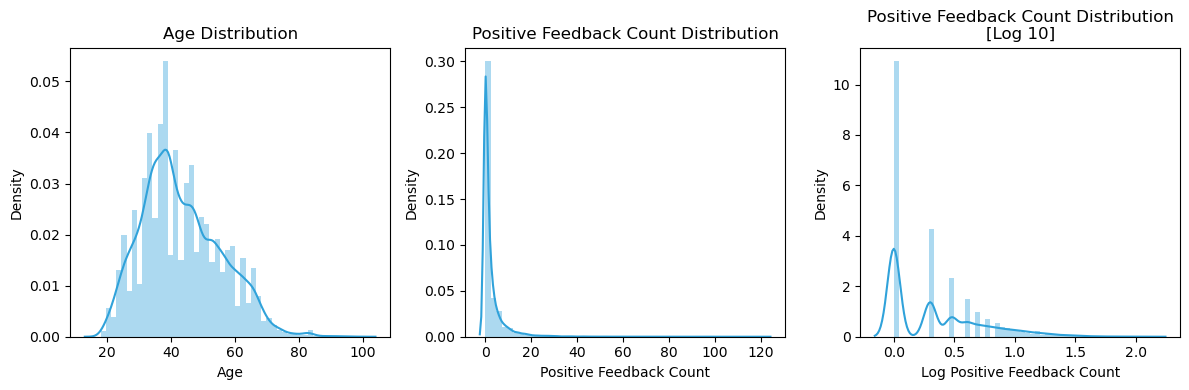

In [11]:
# Continous Distributions
f, ax = plt.subplots(1,3,figsize=(12,4), sharey=False)
sns.distplot(df.Age, ax=ax[0])
ax[0].set_title("Age Distribution")
ax[0].set_ylabel("Density")
sns.distplot(df["Positive Feedback Count"], ax=ax[1])
ax[1].set_title("Positive Feedback Count Distribution")
sns.distplot(np.log10((df["Positive Feedback Count"][df["Positive Feedback Count"].notnull()]+1)), ax=ax[2])
ax[2].set_title("Positive Feedback Count Distribution\n[Log 10]")
ax[2].set_xlabel("Log Positive Feedback Count")
plt.tight_layout()
plt.show()

**Code Explanation:** <br>
Using seaborn, a simple variable frequency bar/density plot is created. In the log positive feedback count plot, I had to add 0.0001 to all values so that the logarithm of previously zero values can be taken. Matplotlib's subplots function is employed through assign each plot the **AX** argument.

**Distribution of Age:** <br>
My a priori expectation was that the biggest group of reviewing customers would be young, tech savvy women between the age of 18 and 34. However, this plot would say otherwise, since it appears that not only is the 34 to 50 year old age most engage in reviewing products, they also appear to be the most positive reviewers, since they proportionately give higher more reviews of 5. Before making insight about these point, it would be wise to gather further data on the age distribution of shoppers. Nevertheless, this trend suggest that the core market segment for this clothing brand is women between 34 and 50. With its single peak and slight right tail, the distribution of age is more or less normal.

**Distribution of Positive Feedback Count:** <br>
This kind of distribution is common for network effect phenomenon, where popularity has an exponential effect on response, and most individuals receive no attention. This phenomenon is also known as the *Cumulative-Advantage Effect / Matthew Effect* or the Pareto Principle.

**Cumulative-Advantage Effect / Matthew Effect:** <br>
Coined by Robert K. Merton in 1968, this [states that once a social agent gains a small advantage over other agents, that advantage will compound over time into an increasingly larger advantage.](http://www.thwink.org/sustain/glossary/CumulativeAdvantagePrinciple.htm) Here is the passage from the New Testament:

>"For to everyone who has will more be given, and he will have abundance; but from him who has not, even what he has will be taken away."
> Matthew 25:29

This tendency effects any system with a positive feedback loop, which compounds. This effect turns out to be quite common among competing agents, and what we end up with, is a the Pareto Distribution.

**Pareto Distribution:** <br>
Also known as the 80/20 rule. Often used to describe the distribution of wealth, 20% of the population hold 80% of the wealth. I wonder how accurate this rule of thumb applies to the distribution of Positive Feedback.

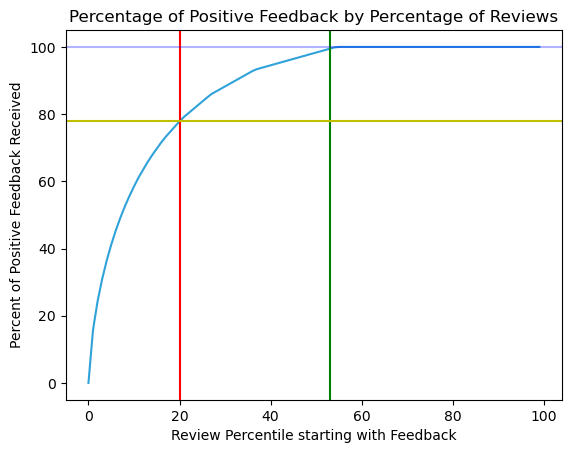

78% of Positive Feedback belongs to the top 20% of Reviews

Gini Coefficient: 0.76


In [12]:
# Percentage Accumulation from "Most Wealthy"
def percentage_accumulation(series, percentage):
    return (series.sort_values(ascending=False)
            [:round(series.shape[0]*(percentage/100))]
     .sum()/series
     .sum()*100)

# Gini Coefficient- Inequality Score
# Source: https://planspace.org/2013/06/21/how-to-calculate-gini-coefficient-from-raw-data-in-python/
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area

# Cumulative Percentage of Positive Feedback assigned Percent of Reviewers (from most wealthy)
inequality = []
for x in list(range(100)):
    inequality.append(percentage_accumulation(df["Positive Feedback Count"], x))

# Generic Matplotlib Plot
plt.plot(inequality)
plt.title("Percentage of Positive Feedback by Percentage of Reviews")
plt.xlabel("Review Percentile starting with Feedback")
plt.ylabel("Percent of Positive Feedback Received")
plt.axvline(x=20, c = "r")
plt.axvline(x=53, c = "g")
plt.axhline(y=78, c = "y")
plt.axhline(y=100, c = "b", alpha=.3)
plt.show()

# 80-20 Rule Confirmation
print("{}% of Positive Feedback belongs to the top 20% of Reviews".format(
    round(percentage_accumulation(df["Positive Feedback Count"], 20))))

# Gini
print("\nGini Coefficient: {}".format(round(gini(df["Positive Feedback Count"]),2)))

**Interpretation:** <br>
In this case, the 80/20 rule applies pretty closely. Nevertheless do not take this rule as granted, since sometimes the proportion of inequality may be much higher! Since the Pareto Principle is a power law, it is fundamentally embedded in itself. However, notice the green vertical line, where 47% of reviews received *no* feedback at all.

Since I am on the topic of inequaliy, I want to quickly touch the Gini Coefficient.

Next, lets see what happens when we look at the top 20% of the top 20%...

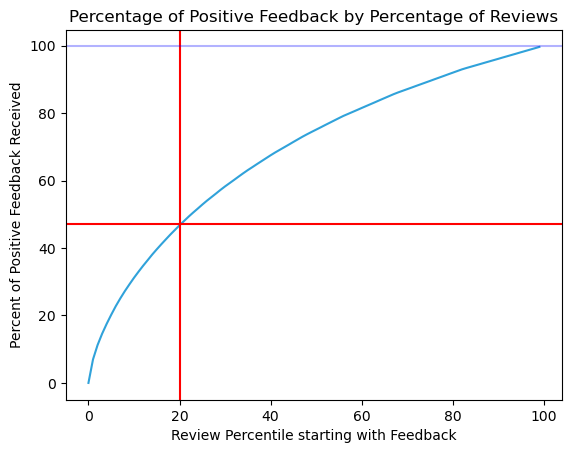

47% of Positive Feedback belongs to the top 20% of Reviews

Gini Coefficient: 0.38


In [13]:
# Cumulative Percentage of Positive Feedback assigned Percent of Reviewers (from most wealthy)
top_20 = df["Positive Feedback Count"].sort_values(ascending=False)[:round(df.shape[0]*(20/100))]

inequality = []
for x in list(range(100)):
    inequality.append(percentage_accumulation(top_20, x))

# Generic Matplotlib Plot
plt.plot(inequality)
plt.title("Percentage of Positive Feedback by Percentage of Reviews")
plt.xlabel("Review Percentile starting with Feedback")
plt.ylabel("Percent of Positive Feedback Received")
plt.axvline(x=20, c = "r")
plt.axhline(y=47, c = "r")
plt.axhline(y=100, c = "b", alpha=.3)

plt.show()

# 80-20 Rule Confirmation
print("{}% of Positive Feedback belongs to the top 20% of Reviews".format(
    round(percentage_accumulation(top_20, 20))))

# Gini
print("\nGini Coefficient: {}".format(round(gini(top_20),2)))

**Interpretation:** <br>
Oh look it didn't hold up. Well think about, the compounding influence of the Network Effect as as whole accounts for the sizable portion of the population that receive nothing.

***

**Division Name and Department Name Distribution:**

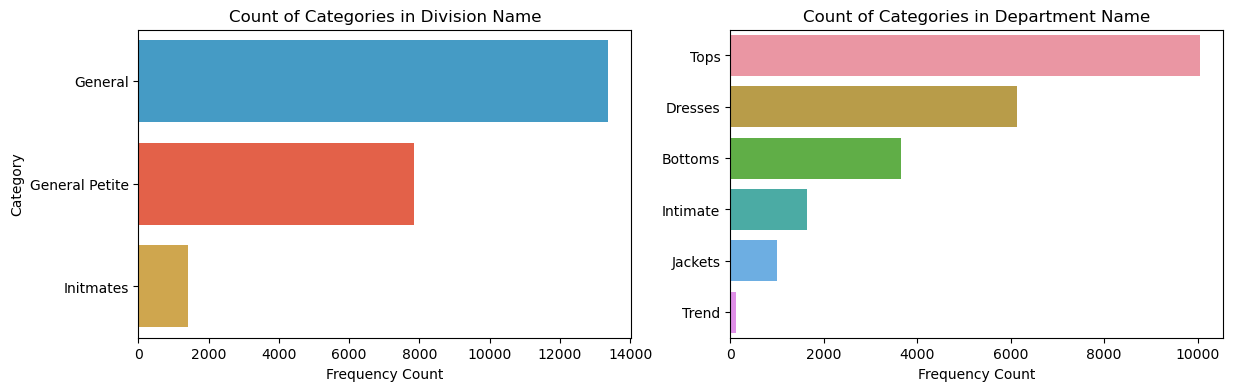

In [14]:
row_plots = ["Division Name","Department Name"]
f, axes = plt.subplots(1,len(row_plots), figsize=(14,4), sharex=False)

for i,x in enumerate(row_plots):
    sns.countplot(y=x, data=df,order=df[x].value_counts().index, ax=axes[i])
    axes[i].set_title("Count of Categories in {}".format(x))
    axes[i].set_xlabel("")
    axes[i].set_xlabel("Frequency Count")
axes[0].set_ylabel("Category")
axes[1].set_ylabel("")
plt.show()

**Code Explanation:** <br>
Enumerating the loop enables the loop iteration to coincide with the matplotlib subplot ax.

**Distribution of Division Name** <br>
This high level feature describes had three categories: General, Petite, and Intimates. This offers some insight into the clothing sizes of the customers leaving reviews.

**Distribution of Department Name** <br>
It is notable to observe that *Tops and Dresses* are the most commonly reviewed products. It would be interesting to investigate the motivation of leaving a review in the first place.

***
**Distribution of Clothing ID to Understand Product Popularity**

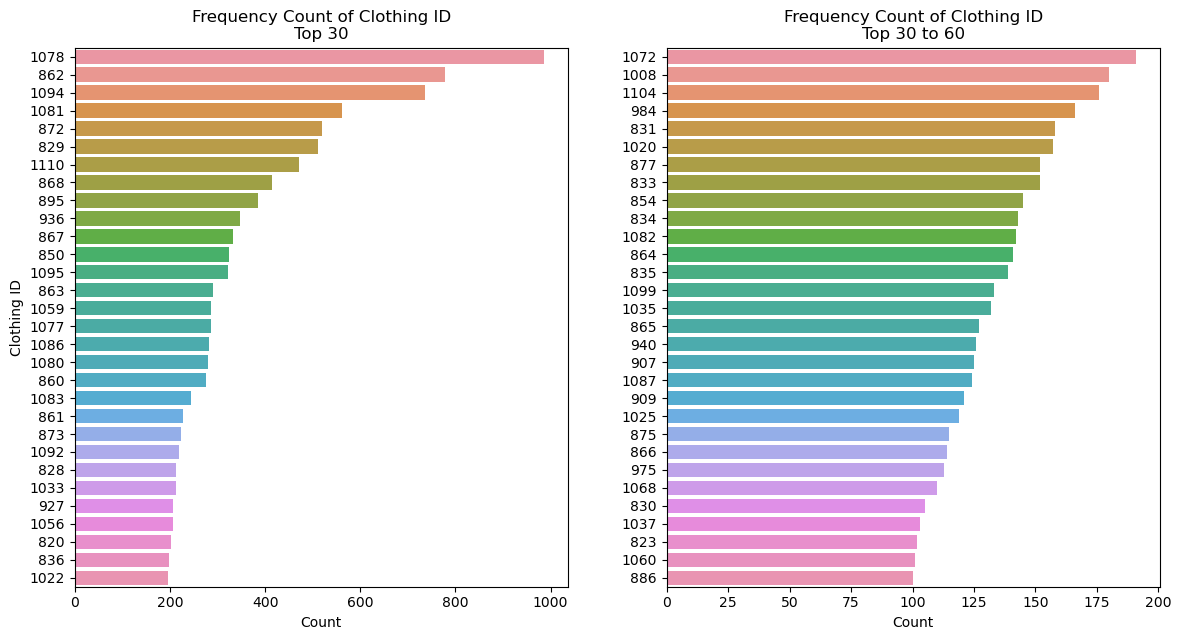

Dataframe Dimension: 22628 Rows


,mean,std,min,25%,50%,75%,max
Clothing ID,1015.4848,103.396022,862.0,862.0,1078.0,1094.0,1094.0
Age,42.7248,12.150429,18.0,34.0,41.0,51.0,99.0
Rating,4.1892,1.104306,1.0,4.0,5.0,5.0,5.0
Recommended IND,0.8184,0.385592,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,2.8624,6.773021,0.0,0.0,1.0,3.0,98.0
Word Count,60.5912,28.731486,2.0,36.0,60.0,89.0,115.0
Character Count,310.8604,144.836158,16.0,189.0,305.0,469.0,504.0
Label,0.9024,0.296832,0.0,1.0,1.0,1.0,1.0


In [15]:
# Clothing ID Category
f, axes = plt.subplots(1,2, figsize=[14,7])
num = 30
sns.countplot(y="Clothing ID", data = df[df["Clothing ID"].isin(df["Clothing ID"].value_counts()[:num].index)],
              order= df["Clothing ID"].value_counts()[:num].index, ax=axes[0])
axes[0].set_title("Frequency Count of Clothing ID\nTop 30")
axes[0].set_xlabel("Count")

sns.countplot(y="Clothing ID", data = df[df["Clothing ID"].isin(df["Clothing ID"].value_counts()[num:60].index)],
              order= df["Clothing ID"].value_counts()[num:60].index, ax=axes[1])
axes[1].set_title("Frequency Count of Clothing ID\nTop 30 to 60")
axes[1].set_ylabel("")
axes[1].set_xlabel("Count")
plt.show()

print("Dataframe Dimension: {} Rows".format(df.shape[0]))
df[df["Clothing ID"].isin([1078, 862,1094])].describe().T.drop("count",axis=1)

In [16]:
df.loc[df["Clothing ID"].isin([1078, 862,1094]),
       ["Title", "Division Name","Department Name","Class Name"]].describe(include=["O"]).T.drop("count",axis=1)

,unique,top,freq
Title,1815,Beautiful dress,21
Division Name,2,General,1524
Department Name,2,Dresses,1722
Class Name,2,Dresses,1722


**Code Explanation** <br>
Since they are around one thousand unique *Clothing IDs*, I used boolean operators to only select the top 60 most popular cloth items, then optimizing notebook real estate by splitting them in two plot columns.

**Interpretation** <br>
It appears like there are around three products that receive a small magnitude more reviews than others. I follow up on these findings by observing the descriptive statistics of the top three items. These items received an average rating of ~4.2, and an average recommendation rate of 81%. Furthermore, it appears that these products are predominately normal sized dresses.

These observations make me wonder about the nature of review popularity and rating performance. A question that could shed light on the customer's motivation to leave a review.

***
**Distribution of Class Name**

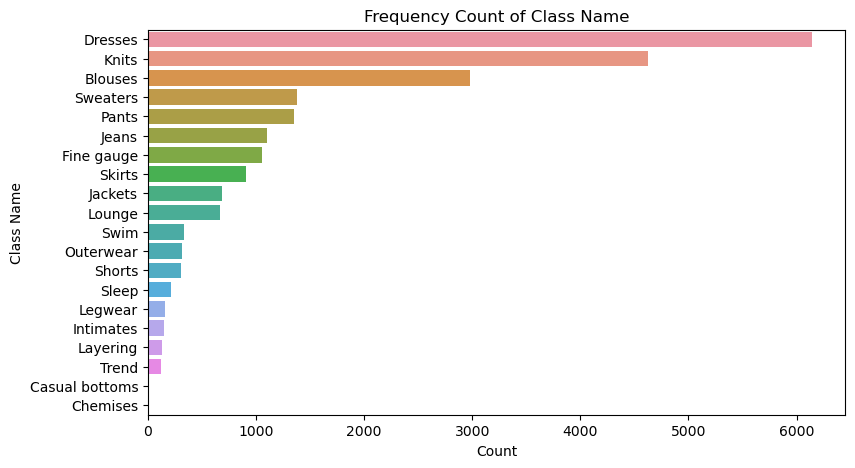

In [17]:
# Class Name
plt.subplots(figsize=(9,5))
sns.countplot(y="Class Name", data=df,order=df["Class Name"].value_counts().index)
plt.title("Frequency Count of Class Name")
plt.xlabel("Count")
plt.show()

**Interpretation:** <br>
Exploring the class variable suggests that the most popular clothing types are: Petite and Anthro, Dresses, Blouses, and Cut and Sew Knits. The distribution of reviews is fairly constant, suggesting that there are not negative nor positive outliers. This statement has been further verified by taking the mean of the label by class group. The results show that no class falls above .80, and the majority rest at .90. Casual bottoms and Chemises scored the highest in this criteria with a 100% positive review rate, however upon investigation this is because only 4 reviews were made in these categories.

***
**Distribution of Rating, Recommended IND, and Label:**

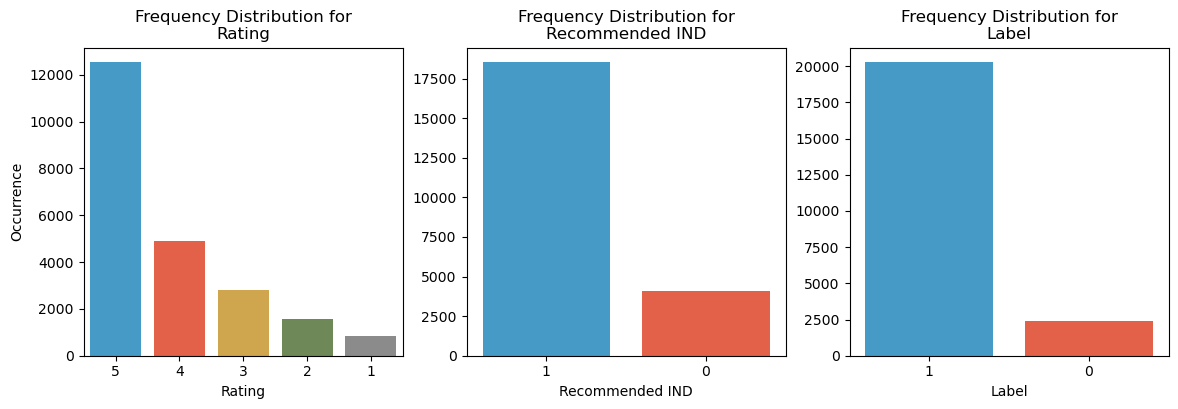

In [18]:
#cat_dtypes = [x for x,y,z in unique_count if y < 10 and x not in ["Division Name","Department Name"]]
cat_dtypes = ["Rating","Recommended IND","Label"]
increment = 0
f, axes = plt.subplots(1,len(cat_dtypes), figsize=(14,4), sharex=False)

for i in range(len(cat_dtypes)):
    sns.countplot(x=cat_dtypes[increment], data=df,order=df[cat_dtypes[increment]].value_counts().index, ax=axes[i])
    axes[i].set_title("Frequency Distribution for\n{}".format(cat_dtypes[increment]))
    axes[i].set_ylabel("Occurrence")
    axes[i].set_xlabel("{}".format(cat_dtypes[increment]))
    increment += 1
axes[1].set_ylabel("")
axes[2].set_ylabel("")
plt.show()

**Code Explanation:**
Yet another way to iterate plots, where I both loop over the index position of cat_dtypes and subplot ax at the same time with range of the length of cat_dtypes.

**Distribution of Rating:** <br>
The vast majority of reviews were highly positive, with a score of five out of five. This suggests that this retail store is performing fairly well, but then again, I am not familiar with the industry benchmark. Competitor reviews may be scraped and analyzed. It is important to note that these reviews are subjective, and some negative reviews may a outcome of a bad day, instead of constructive feedback. In the plot below, the Label plot is the binary classification of 1 = good, and 0= bad.

**Distribution of Recommended IND:** <br>
This variable mirrors the positivity of the Rating distribution, but as mentioned earlier, I believe that it provides variation of positivity which is social, rather than personal.

**Distribution of Label:** <br>
I am surprised to see that products are rated 3 and over, than are recommended by the customer. I am eager to see the multivariate interaction between Rating and Recommended.

I find these three variables especially promising in the quest of finding how customers express dislike. In the multivariate section, I shall explore the interplay between these variables.

***
**Word and Length:**

AttributeError: 'NoneType' object has no attribute 'remove'

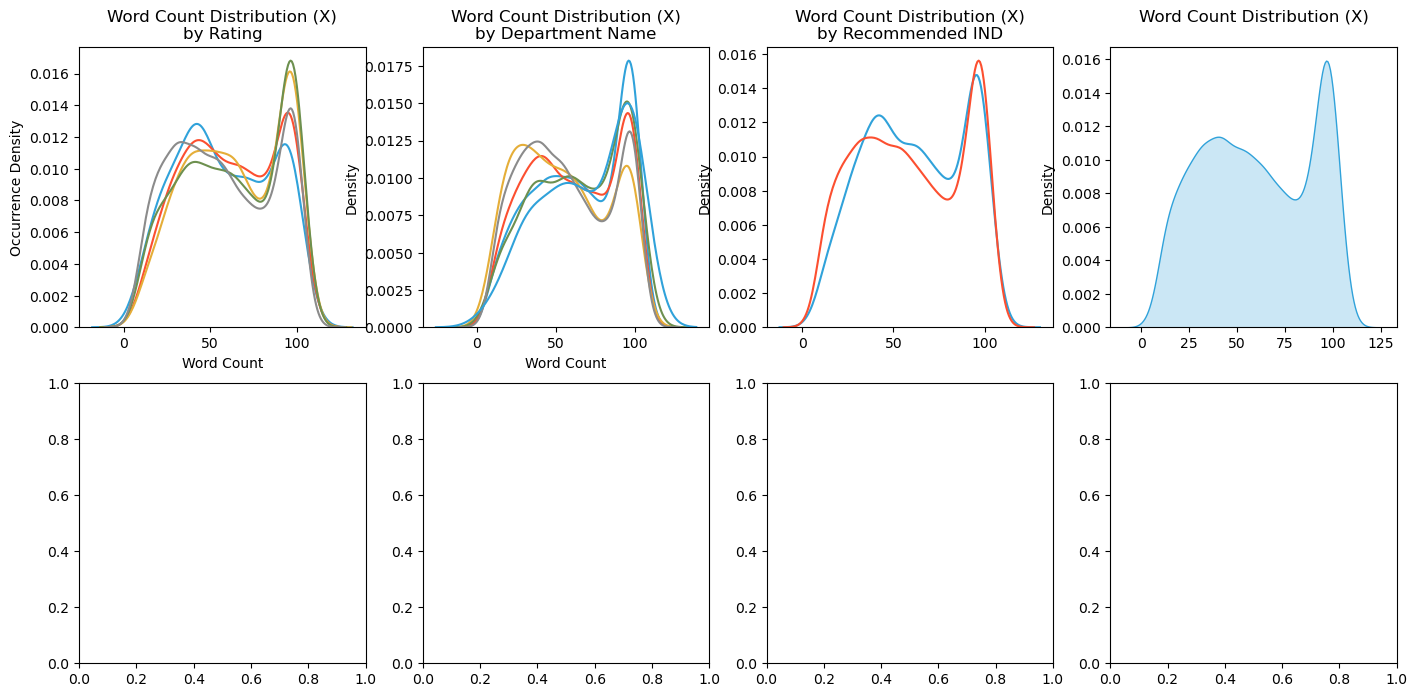

In [19]:
f, axes = plt.subplots(2,4, figsize=(17,8), sharex=False)
for ii, xvar in enumerate(['Word Count', "Character Count"]):
    for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
        for x in set(df[y][df[y].notnull()]):
            sns.kdeplot(df[xvar][df[y]==x], label=x, shade=False, ax=axes[ii,i])
        if ii is 0:
            axes[ii,i].set_title('{} Distribution (X)\nby {}'.format(xvar, y))
        else:
            axes[ii,i].set_title('For {} (X)'.format(xvar))
    axes[ii,0].set_ylabel('Occurrence Density')
    axes[ii,i].set_xlabel('')
    # Plot 4
    sns.kdeplot(df[xvar],shade=True,ax=axes[ii,3])
    axes[ii,3].set_xlabel("")
    if ii is 0:
        axes[ii,3].set_title('{} Distribution (X)\n'.format(xvar))
    else:
        axes[ii,3].set_title('For {} (X)'.format(xvar))
    axes[ii,3].legend_.remove()
plt.show()

print("Correlation Coefficient of Word Cound and Character Count: {}".format(
    round(df["Word Count"].corr(df["Character Count"]), 2)))

print("\nTotal Word Count is: {}".format(df["Word Count"].sum()))
print("Total Character Count is: {}".format(df["Character Count"].sum()))
df[["Word Count","Character Count"]].describe().T

**Interpretation:** <br>
- Review Character and Word Count are highly correlated.
- I suspect that the retailer has a maximum word limit of 500, which caused the long tail to receive compression and spike. 

***

## 3. Multivariate Distribution <a id="Multivariate"></a>
### 3.1 Categorical Variable by Categorical Variable
In this section, I utilize heatmaps to visualize the percentage occurrence pivot table. Note that I heavily utilized the technique of normalizing the proportion between variables classes by converting frequency into percentages. This technique is very fruitful because the relation upon which the percentage can be explored by aggregate, by index, and by column, each of which providing its own unique insight.

**Division Name by Department Name:**

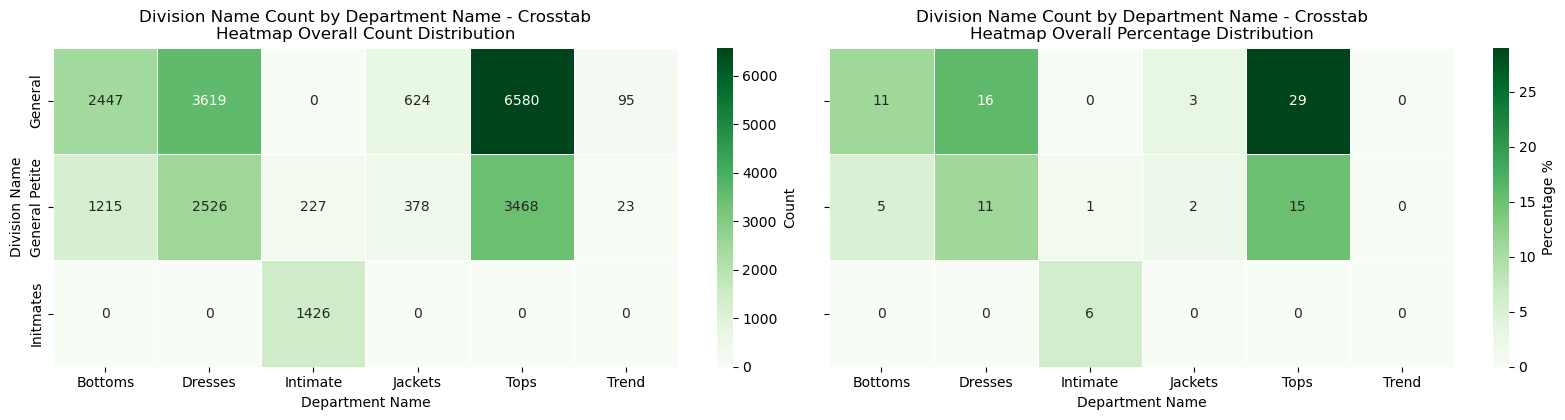

In [20]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(16, 4), sharey=True)
sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"]),
            annot=True, linewidths=.5, ax = ax[0],fmt='g', cmap="Greens",
                cbar_kws={'label': 'Count'})
ax[0].set_title('Division Name Count by Department Name - Crosstab\nHeatmap Overall Count Distribution')

sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap="Greens",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Division Name Count by Department Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

**How to Interpret:** <br>
For the second heatmap on the right, the percentages occurrence is in relation to the whole.

**Interpretation:** <br>
Evidently, the most common product is a normal sized top.

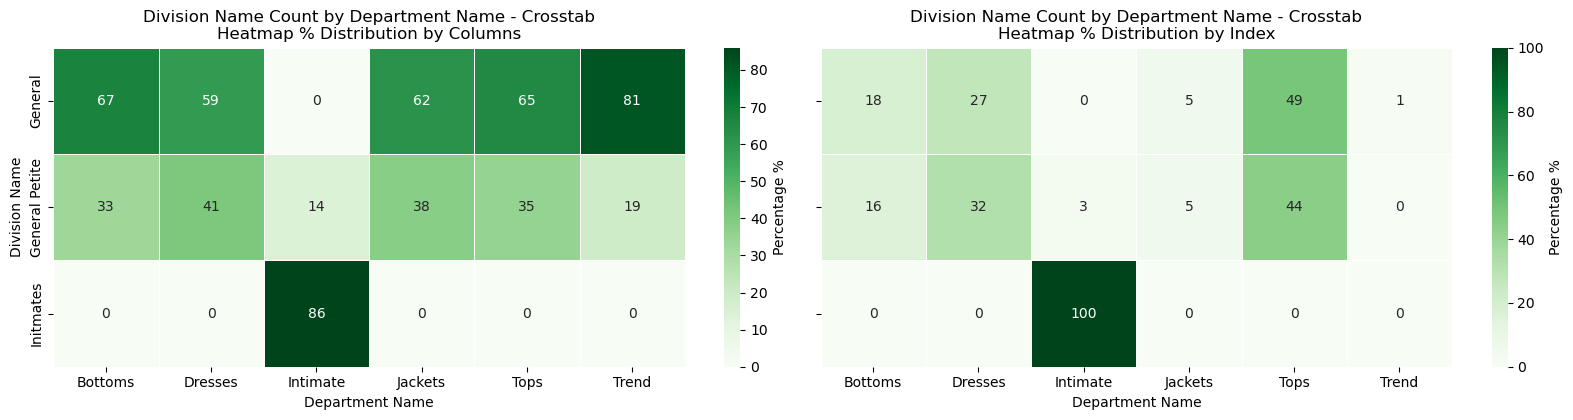

In [21]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(16, 4), sharey=True)
sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"], normalize='columns').mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[0],fmt='g', cmap="Greens",
                cbar_kws={'label': 'Percentage %'})
ax[0].set_title('Division Name Count by Department Name - Crosstab\nHeatmap % Distribution by Columns')

sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"], normalize='index').mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap="Greens",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Division Name Count by Department Name - Crosstab\nHeatmap % Distribution by Index')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

**How to Interpret:** <br>
Although these two heatmaps use the same features, they different in the relation in which the percentage is taken. For the first plot on the left, the percentages add up to 100% by **column**, while the plot on the right has is **normalized into percentages by row**.

**Interpretation:** <br>
The dominance of the *General* size is consistent across the various categories within **Department Name**. There a notable overall between *General Petite* and *Department Name*.

***

**Class Name by Department Name:**

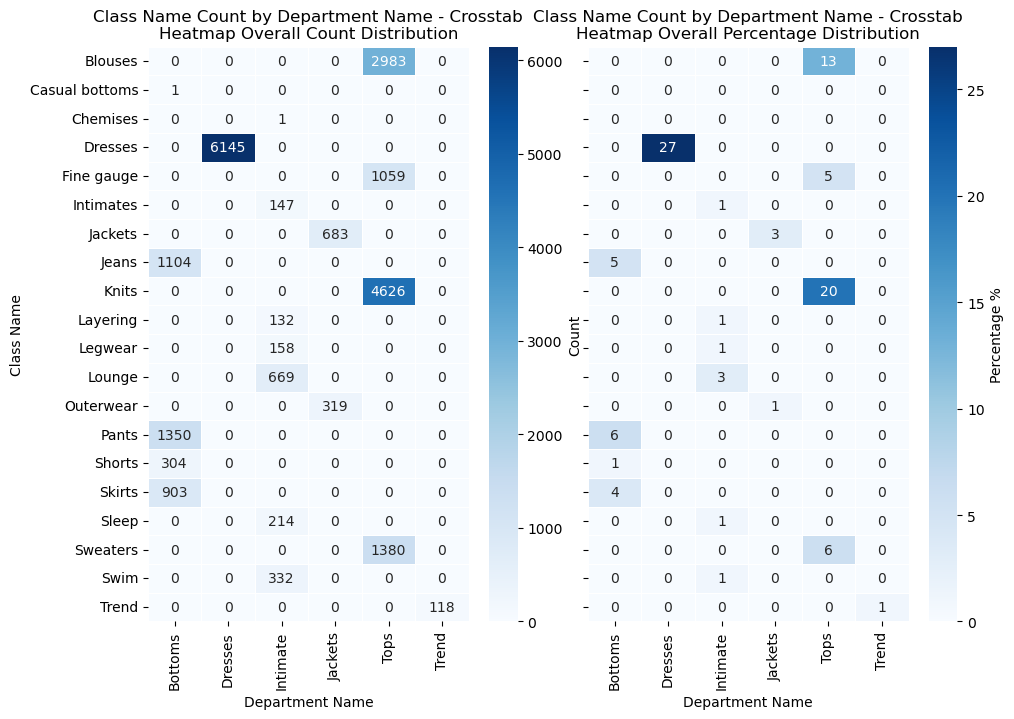

In [22]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(10, 7), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df["Department Name"]),
            annot=True, linewidths=.5, ax = ax[0],fmt='g', cmap="Blues",
                cbar_kws={'label': 'Count'})
ax[0].set_title('Class Name Count by Department Name - Crosstab\nHeatmap Overall Count Distribution')

sns.heatmap(pd.crosstab(df['Class Name'], df["Department Name"], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap="Blues",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Department Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

**Interpretation:** <br>
Here we get a closer glimpse at the breakdown of specific clothing types. Up to now, the dominance of dress popularity has been evident, but not that of "Knits". This is a kind of thickly thread and colorful top item which I must confess I have not seen much of out in the real world.

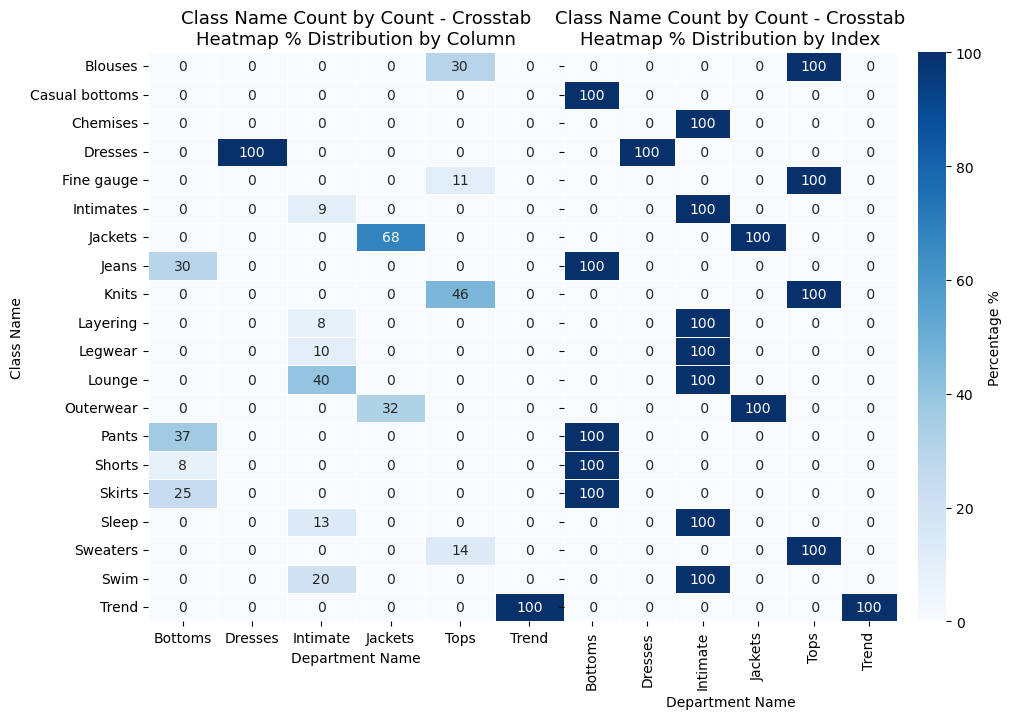

In [23]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(10, 7), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df["Department Name"], normalize = 'columns').mul(100).round(0)
            ,annot=True, fmt="g", linewidths=.5, ax=ax[0],cbar=False,cmap="Blues")
ax[0].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Column', fontsize = fsize)
ax[1] = sns.heatmap(pd.crosstab(df['Class Name'], df["Department Name"], normalize = 'index').mul(100).round(0)
            ,annot=True, fmt="2g", linewidths=.5, ax=ax[1],cmap="Blues",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Index', fontsize = fsize)
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

**Interpretation:**
This normalization of percentage by column and index explains how clothing types are distributed across departments. This provides a clear way to see which products are dominant within each category. Following up on knits, it appears that the runner up in the "Tops" category, "Blouses", is not that far behind.

***
**Division Name by Department Name:**

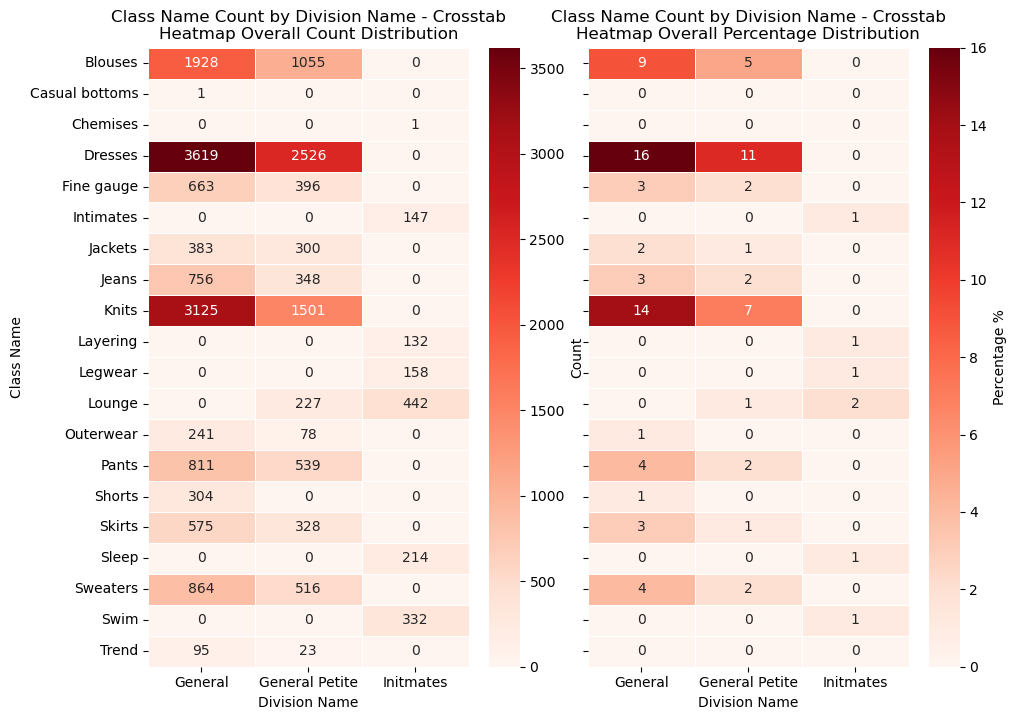

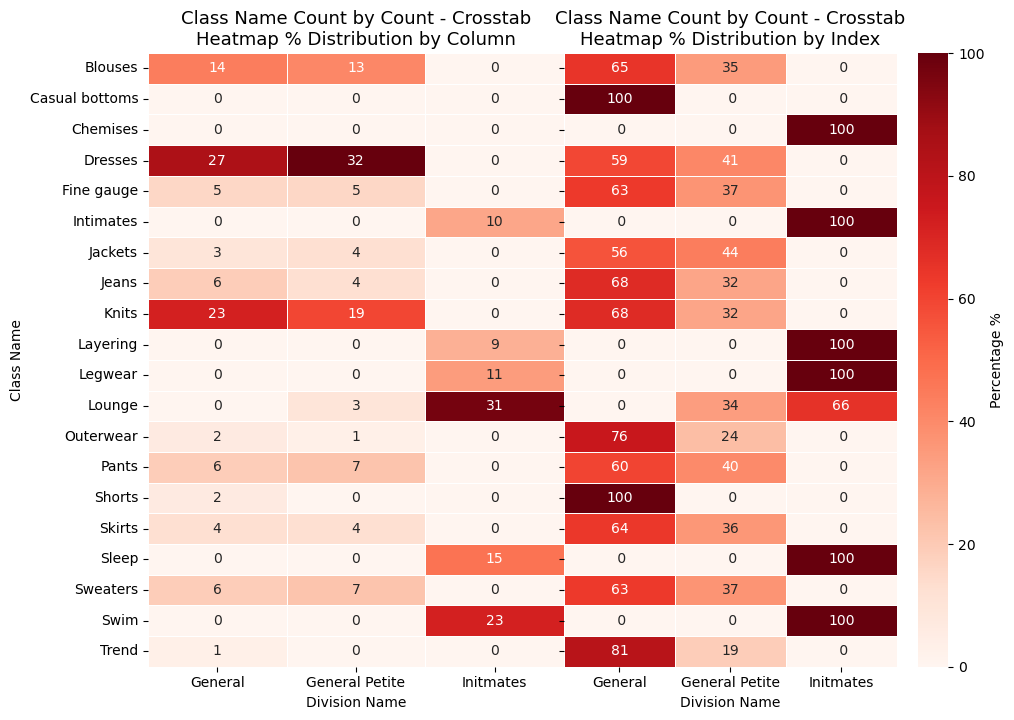

In [24]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(10, 7), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df["Division Name"]),
            annot=True, linewidths=.5, ax = ax[0],fmt='g', cmap="Reds",
                cbar_kws={'label': 'Count'})
ax[0].set_title('Class Name Count by Division Name - Crosstab\nHeatmap Overall Count Distribution')

sns.heatmap(pd.crosstab(df['Class Name'], df["Division Name"], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap="Reds",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Division Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(10, 7), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df["Division Name"], normalize = 'columns').mul(100).round(0)
            ,annot=True, fmt="g", linewidths=.5, ax=ax[0],cbar=False,cmap="Reds")
ax[0].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Column', fontsize = fsize)
ax[1] = sns.heatmap(pd.crosstab(df['Class Name'], df["Division Name"], normalize = 'index').mul(100).round(0)
            ,annot=True, fmt="2g", linewidths=.5, ax=ax[1],cmap="Reds",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Index', fontsize = fsize)
ax[1].set_ylabel('')
plt.tight_layout(pad=0)

# MANUAL NORMALIZE with Applied Lambda on Pandas DataFrame
# ctab = pd.crosstab(df['Class Name'], df["Rating"]).apply(lambda r: r/r.sum(), axis=1).mul(100)

**Interpretation:** <br>
I think this plot wraps up the interplay between Blouses, Dresses, and Knits by showing that most reviews revolve around the normal sized version of the products. It is interesting to note that Dresses attract higher proportion of "Petite" sized customers.

***
### 3.2  Continuous Variable by Categorical Variable

Here I want to look at the behavior of the continuous variables when sliced by various categorical variables. The general theme of this section is that there is no clear slicing of continuous on categorical variables that provide a clear, distinct pattern.

**Positive Feedback Count Distribution by Rating, Department Name, Recommended IND, and Class Name**

AttributeError: 'NoneType' object has no attribute 'remove'

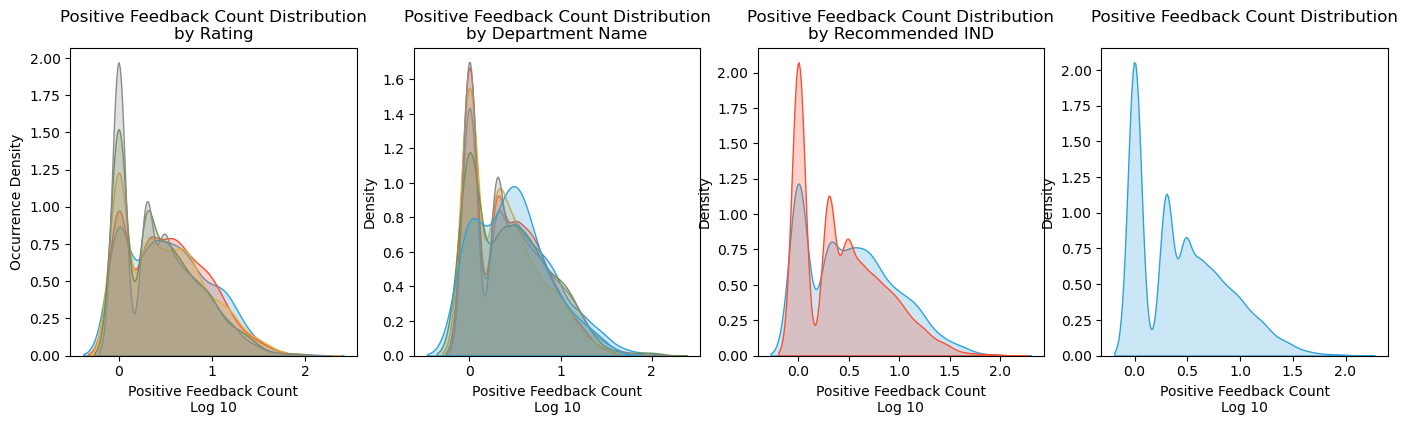

In [25]:
f, axes = plt.subplots(1,4, figsize=(17,4), sharex=False)
xvar = 'Positive Feedback Count'
plotdf = np.log10(df['Positive Feedback Count'])
for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
    for x in set(df[y][df[y].notnull()]):
        sns.kdeplot(plotdf[df[y]==x], label=x, shade=True, ax=axes[i])
    axes[i].set_xlabel("{}\nLog 10".format(xvar))
    axes[i].set_label('Occurrence Density')
    axes[i].set_title('{} Distribution\nby {}'.format(xvar, y))
axes[0].set_ylabel('Occurrence Density')
# Plot 4
sns.kdeplot(plotdf,shade=True,ax=axes[3])
axes[3].set_xlabel("{}\nLog 10".format(xvar))
axes[3].set_title('{} Distribution\n'.format(xvar))
axes[3].legend_.remove()
plt.show()

**Interpretation:** <br>
Since Positive Feedback Count is in log form, the higher frequency of non-recommended [0] has a bigger effect than visually suggested. The more popular reviews are not recommended, which suggest that the content is in the form of constructive criticism.

In [26]:
# Checking inequality difference:
for rec in [0,1]:
    temp = df["Positive Feedback Count"][df["Recommended IND"] == rec]

    print("Recommended is {}".format(rec))
    # 80-20 Rule Confirmation
    print("{}% of Positive Feedback belongs to the top 20% of Reviews with Recommeded = {}".format(
        round(percentage_accumulation(temp, 20)),rec))
    # Gini
    print("Gini Coefficient: {}\n".format(round(gini(temp),2)))

Recommended is 0
75% of Positive Feedback belongs to the top 20% of Reviews with Recommeded = 0
Gini Coefficient: 0.73

Recommended is 1
78% of Positive Feedback belongs to the top 20% of Reviews with Recommeded = 1
Gini Coefficient: 0.76



**Interpretation:** <br>
The difference is not huge, but nevertheless, a higher gini coefficient signigies higher inequality. This means that there is a bigger divergence between recommended reviews than there is between non-recommended reviews.

***

**Positive Feedback Count by Class Name:** <br>

AttributeError: 'NoneType' object has no attribute 'remove'

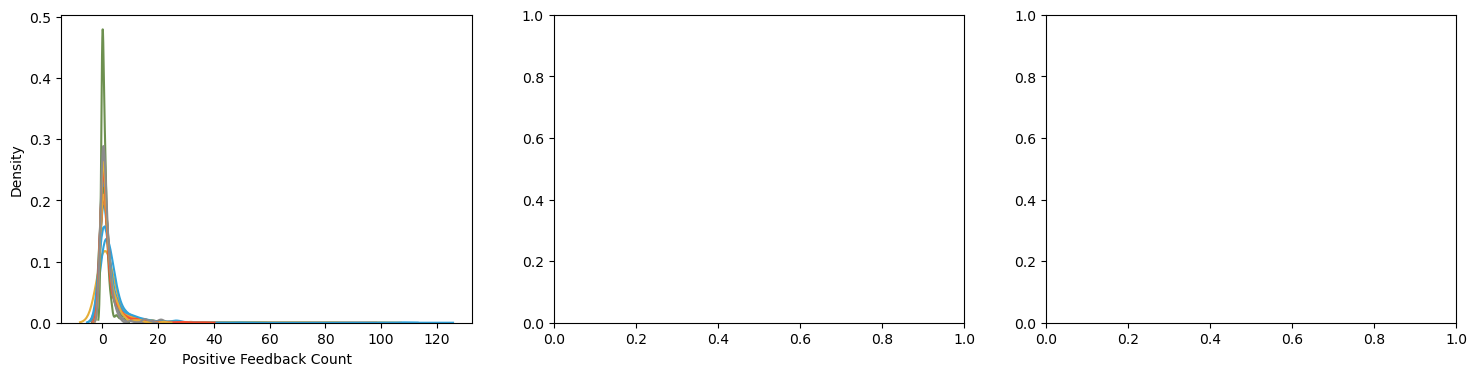

In [27]:
f, axes = plt.subplots(1,3, figsize=(18,4), sharex=False)
for x in set(df["Class Name"][df["Class Name"].notnull()]):
    sns.kdeplot(df['Positive Feedback Count'][df["Class Name"]==x]
                ,label=x, shade=False, ax=axes[0])
    
axes[0].legend_.remove()
axes[0].set_xlabel('{}'.format(xvar))
axes[0].set_title('{} Distribution by {}\n All Data'.format(xvar, "Class Name"))

min_value = 15
for x in set(df["Class Name"][df["Class Name"].notnull()]):
    sns.kdeplot(df['Positive Feedback Count'][(df["Class Name"]==x) &
                                              (df["Positive Feedback Count"] < min_value)]
                ,label=x, shade=False, ax=axes[1])
    
axes[1].legend_.remove()
axes[1].set_xlabel('{}'.format(xvar))
axes[1].set_title('{} Distribution by {}\n Values under {}'.format(xvar, "Class Name", min_value))

for x in set(df["Class Name"][df["Class Name"].notnull()]):
    sns.kdeplot(np.log10(df['Positive Feedback Count']+1)[df["Class Name"]==x]
                ,label=x, shade=False, ax=axes[2])
    
axes[2].legend_.remove()
axes[2].set_xlabel('Log 10 - {}'.format(xvar))
axes[2].set_title('{} Distribution by {}\nAll Data in Log10'.format(xvar, "Class Name"))
plt.show()

Not much to say here. There are too many classes to include a legend.. A statistical test method would operate better at this dimensionality.

***
**Age Distribution by the Usual Suspects.. round them up**

AttributeError: 'NoneType' object has no attribute 'remove'

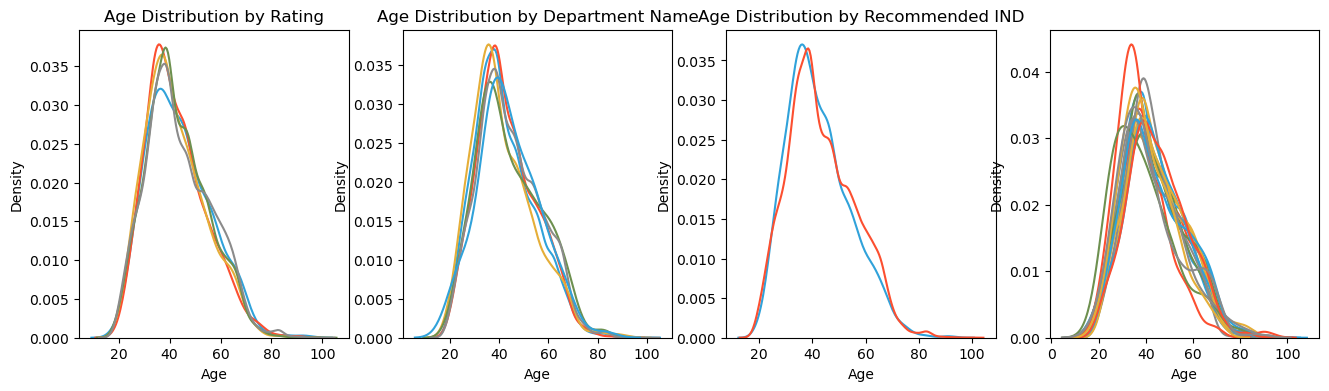

In [28]:
f, axes = plt.subplots(1,4, figsize=(16,4), sharex=False)
xvar = "Age"
plotdf = df["Age"]
for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
    for x in set(df[y][df[y].notnull()]):
        sns.kdeplot(plotdf[df[y]==x], label=x, shade=False, ax=axes[i])
    axes[i].set_xlabel("{}".format(xvar))
    axes[i].set_label('Occurrence Density')
    axes[i].set_title('{} Distribution by {}'.format(xvar, y))

for x in set(df["Class Name"][df["Class Name"].notnull()]):
    sns.kdeplot(plotdf[df["Class Name"]==x], label=x, shade=False, ax=axes[3])

axes[3].legend_.remove()
axes[3].set_xlabel('{}'.format(xvar))
axes[0].set_ylabel('Occurrence Density')
axes[3].set_title('{} Distribution by {}'.format(xvar, "Class Name"))
plt.show()

**Interpretation:** <br>
Unlike Positive Feedback Count, Age has not been transformed into a logarithm. For these reasons, slight noise between the age distribution by these features are nothing to worry about. Age doesn't seem to receive influence on these dimensions.

***

### 3.3 Continuous Variables  on Continuous Variables

Time for some scatter plots. with [Seaborn Joint Plot](https://tryolabs.com/blog/2017/03/16/pandas-seaborn-a-guide-to-handle-visualize-data-elegantly/).

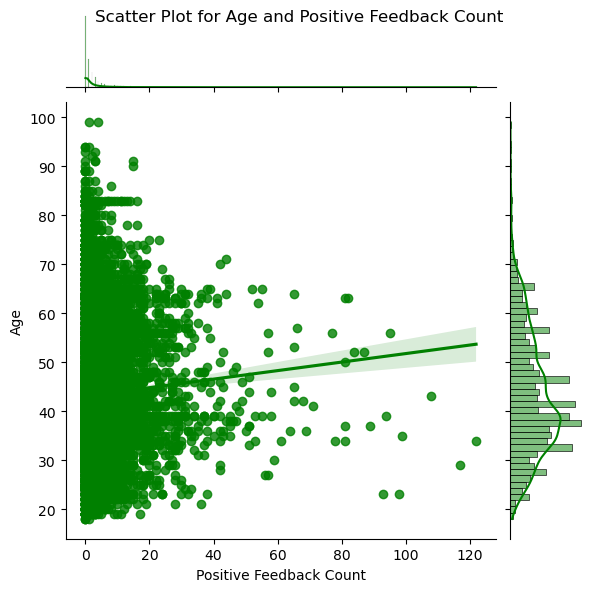

In [29]:
# Normalization is futile here.. But here is a minmax standardization, and a z-score normalization function. 
def minmaxscaler(df):
    return (df-df.min())/(df.max()-df.min())
def zscorenomalize(df):
    return (df - df.mean())/df.std()

g = sns.jointplot(x= df["Positive Feedback Count"], y=df["Age"], kind='reg', color='g')
g.fig.suptitle("Scatter Plot for Age and Positive Feedback Count")
plt.show()

**How to Interpret:** <br>
Don't be deceived by the seemingly numerous amount of points over the Positive Feedback Count value of 0! The distribution plot up top clearly shows that most points reside at ZERO!

**Interpretation:** <br>
There appears to be a slight correlation between age and positive feedback count received. It would be interesting to focus on the textual anatomy of high positive feedback reviews.
***

### 3.4 Percentage Standardize Distribution Plots

Since many variables are severely unbalanced, I employ standardization by percentage to see if the proportion is consistent between categorical classes. This is the same idea used previously on heatmaps now applied to barcharts!

[Percentage Standardize in Seaborn - Stackoverflow](https://stackoverflow.com/questions/34615854/seaborn-countplot-with-normalized-y-axis-per-group)

In [30]:
def percentstandardize_barplot(x,y,hue, data, ax=None, order= None):
    """
    Standardize by percentage the data using pandas functions, then plot using Seaborn.
    Function arguments are and extention of Seaborns'.
    """
    sns.barplot(x= x, y=y, hue=hue, ax=ax, order=order,
    data=(data[[x, hue]]
     .reset_index(drop=True)
     .groupby([x])[hue]
     .value_counts(normalize=True)
     .rename('Percentage').mul(100)
     .reset_index()
     .sort_values(hue)))
    plt.title("Percentage Frequency of {} by {}".format(hue,x))
    plt.ylabel("Percentage %")

**Code Explanation:** <br>
Many transformation are conducted here.
- Groupby([x])[hue]: Groups the data by the x variable, what will become the X axis of the barplot.
- Value_counts(normalized=True): Then the hue variable, which is rowed by the x variable, is ordered by most frequent to least, and that value is converted to decimal percentage.
- rename().mull(100): Then this is renamed to "Percentage", and the decimal value is multiplied by 100 to be in proper percentage units.

***
**Recommended IND by Department and Division**

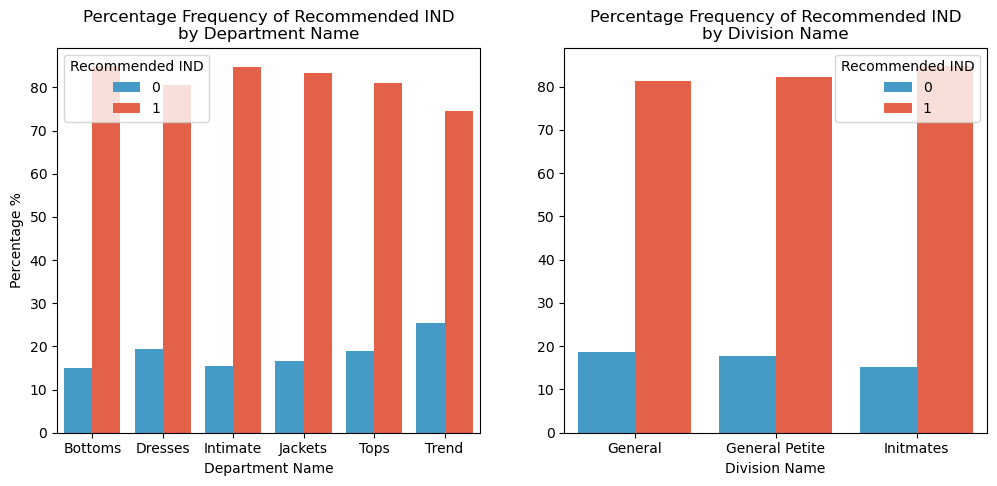

In [31]:
huevar = "Recommended IND"
f, axes = plt.subplots(1,2,figsize=(12,5))
percentstandardize_barplot(x="Department Name",y="Percentage", hue=huevar,data=df, ax=axes[0])
axes[0].set_title("Percentage Frequency of {}\nby Department Name".format(huevar))
axes[0].set_ylabel("Percentage %")
percentstandardize_barplot(x="Division Name",y="Percentage", hue=huevar,data=df, ax=axes[1])
axes[1].set_title("Percentage Frequency of {}\nby Division Name".format(huevar))
axes[1].set_ylabel("")
plt.show()

**Interpretation:** <br>
The finding here is the same as the earlier heatmap. Nothing tremendous.

***
**Rating by Department and Divison Name**

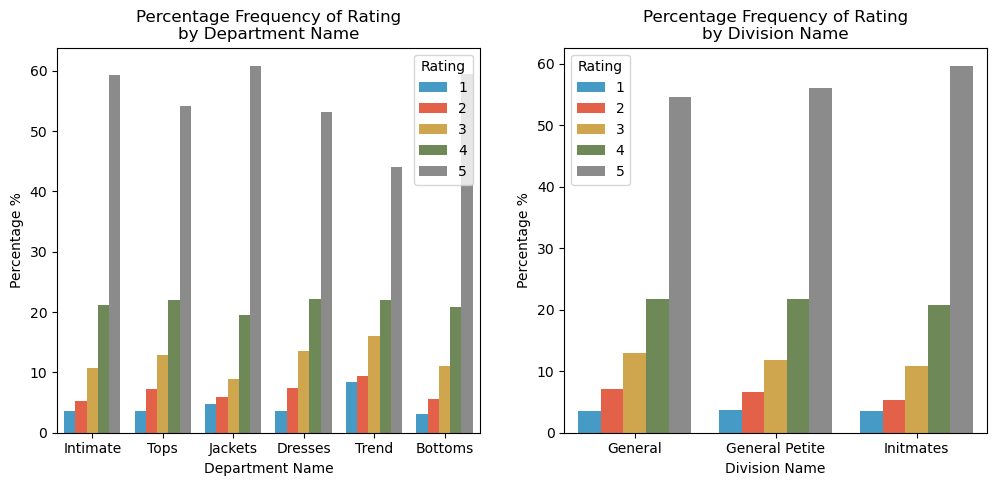

In [32]:
xvar = ["Department Name","Division Name"]
huevar = "Rating"
f, axes = plt.subplots(1,2,figsize=(12,5))
percentstandardize_barplot(x=xvar[0],y="Percentage", hue=huevar,data=df, ax=axes[0])
axes[0].set_title("Percentage Frequency of {}\nby {}".format(huevar, xvar[0]))
axes[0].set_ylabel("Percentage %")
percentstandardize_barplot(x=xvar[1],y="Percentage", hue="Rating",data=df, ax=axes[1])
axes[1].set_title("Percentage Frequency of {}\nby {}".format(huevar, xvar[1]))
plt.show()

**Interpretation:** <br>
Department and Divison are consistent with the overall distribution of Rating.

***
**Positive Feedback Count over 40 by Recomended IND and Rating**

In [33]:
# Cuttoff Variable
df["Cutoff"] = df["Positive Feedback Count"] >= 40 # Temporary variable for facetgrid
# Facet Grid Plot
g = sns.FacetGrid(df, row = "Cutoff", col="Recommended IND",
                  hue="Rating", size=4, aspect=1.1, sharey=False, sharex=False)
g.map(sns.distplot, "Positive Feedback Count", hist=False)
g.add_legend()
g.axes[0,0].set_ylabel('Density')
g.axes[1,0].set_ylabel('Density')
plt.subplots_adjust(top=0.90)
g.fig.suptitle('Positive Feedback Count by Recommended (Column) and Rating (Color) and Cutoff (Feedback >40 is True)')

# Give cutoff line to each plot.
for x in [0,1]:
    for y in [0,1]:
        g.axes[x,y].axvline(x=40, c="r")

plt.show()
del df["Cutoff"]

TypeError: FacetGrid.__init__() got an unexpected keyword argument 'size'

**Code Explanation:** <br>
While I have mostly built my multi-plot visualization configuration from scratch, here is an facetplot example which is less complex, but nevertheless, requires careful planning of new variables/dimensions, such as my "Cutoff" variable.

The red vertical line corresponds to the cutoff rule. Note that KDE likes to smooth out its tails, even though the hard cutoff would contradict this. More realistic representation would appear with a barplot, but the clutter would be too in-intelligible.

**Interpretation:** <br>
As a follow-up on the preview analysis on the dominant high positive feedback count rate of reviews recommended by the customer, this plot offers even more nuance.

First finding is the bump in on the bottom left: Cutoff = True | Recommended IND = 0. Now, this plot explores un-hopeful criticism about certain products, which is why the light blue's (rating = 1) second bump dominates the ~110 positive feedback count range.

The second finding is the the bottom right plot. Here, these are popular reviews which are recommended. It it interesting to see the high spread of the yellow distribution, rating = 3. This indicates that hopeful reviews which offer constructive criticism are the most socially appreciated.

***
**Rating by Recommended IND**


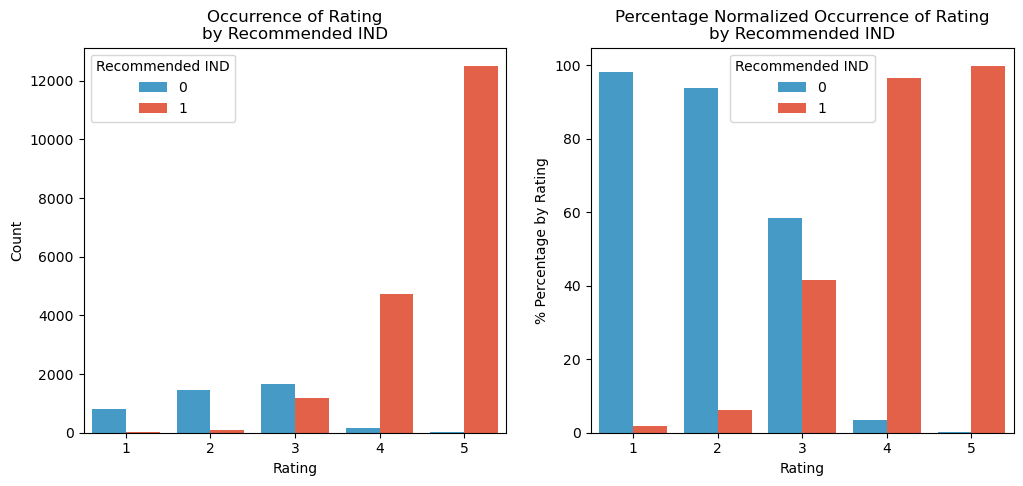

In [34]:
huevar = "Rating"
f, axes = plt.subplots(1,2,figsize=(12,5))
sns.countplot(x="Rating", hue="Recommended IND",data=df, ax=axes[0])
axes[0].set_title("Occurrence of {}\nby {}".format(huevar, "Recommended IND"))
axes[0].set_ylabel("Count")
percentstandardize_barplot(x="Rating",y="Percentage", hue="Recommended IND",data=df, ax=axes[1])
axes[1].set_title("Percentage Normalized Occurrence of {}\nby {}".format(huevar, "Recommended IND"))
axes[1].set_ylabel("% Percentage by Rating")
plt.show()

**Interpretation:** <br>
This is a big one, which returns to my question: "How do customers express their dislike for a Product". There is a conflicting interest between the customers personal interaction with the product, such as the personal size fit, experience, and other personal synergies, and what the customer would invision for other customers.

My theory is that when customers give product a low rating, but nevertheless recommend the item, the customer is protesting about a personal complaint they have, such as a fit issue or customer service and product handling problem all the while still expressing admiration for the product, an approval of style worthy for the body of another.

Looking at the data, it appears like five star ratings are void of non-recommendations, but low rated products are recommended a small amount of the time.

The more even occurrence between recommended and non-recommended on products with three rating is a phenomenon worth getting to the bottom of. Especially the recommended portion of the reviews, which might shed light on the biggest limitations of the retailers personal servicing, and the customers personal clothing experience.

***

## 4. Multivariate Analysis and Descriptive Statistics
<a id="Multianalysis"></a>

In this section, I will no longer look at merely observation count by feature, but also look at how averages and other descriptive statistics behave when cut up.

**Rating by Recommended IND**

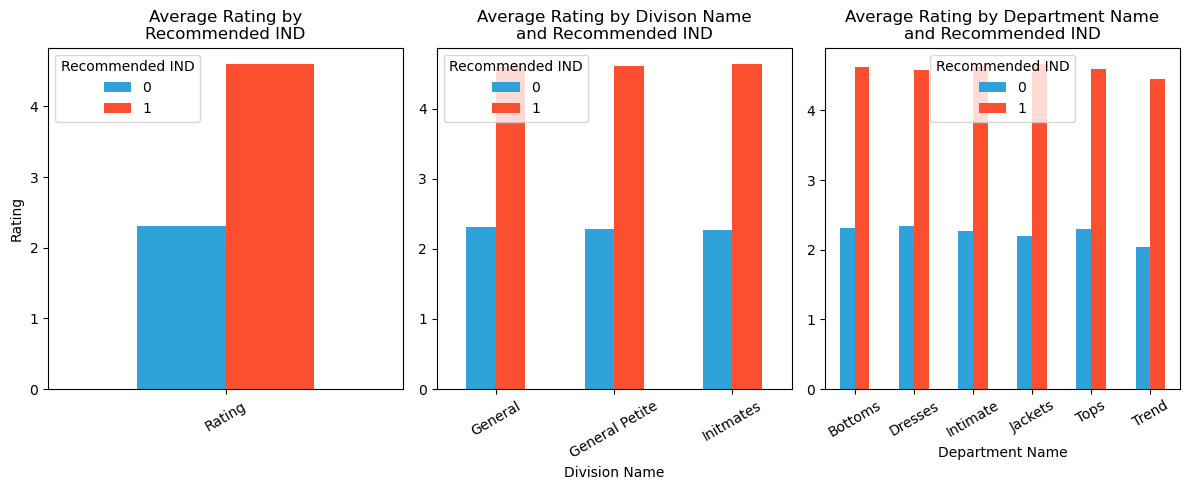

In [35]:
f, axes = plt.subplots(1,3,figsize=(12,5))
rot = 30
df.pivot_table('Rating',
               columns=['Recommended IND']).plot.bar(ax=axes[0],rot=rot)
axes[0].set_title("Average Rating by\nRecommended IND")
df.pivot_table('Rating', index='Division Name',
               columns=['Recommended IND']).plot.bar(ax=axes[1], rot=rot)
axes[1].set_title("Average Rating by Divison Name\nand Recommended IND")
df.pivot_table('Rating', index='Department Name',
               columns=['Recommended IND']).plot.bar(ax=axes[2], rot=rot)
axes[0].set_ylabel("Rating")
axes[2].set_title("Average Rating by Department Name\nand Recommended IND")
f.tight_layout()
plt.show()

**Interpretation:** <br>
Rating is just under max rating when recommended, and halfed when not recommended. Trend is consistent across Division and Department.

***
**Correlating Average Rating and Recommended IND by Clothing ID** <br>
Analysis of data grouped by Clothing ID.

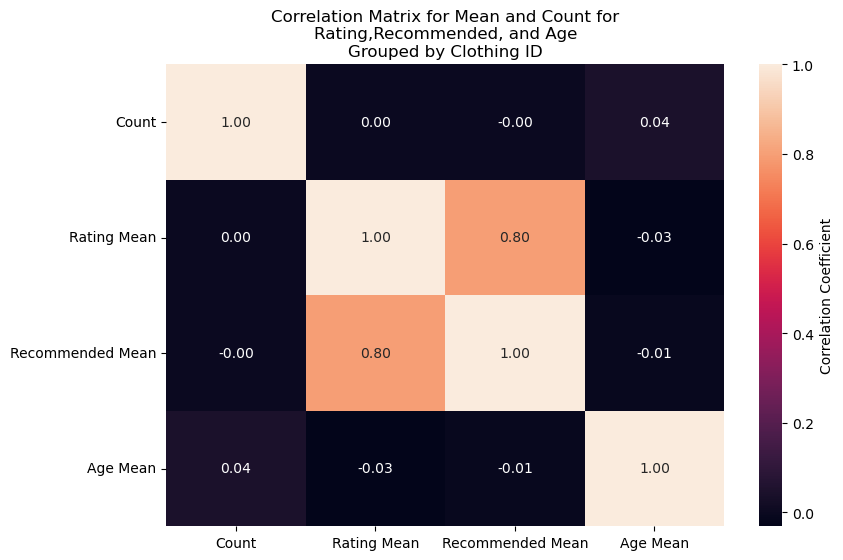

In [36]:
temp = (df.groupby('Clothing ID')[["Rating","Recommended IND", "Age"]]
        .aggregate(['count','mean']))
temp.columns = ["Count","Rating Mean","Recommended IND Count",
                "Recommended Mean","Age Count","Age Mean"]
temp.drop(["Recommended IND Count","Age Count"], axis=1, inplace =True)

# Plot Correlation Matrix
f, ax = plt.subplots(figsize=[9,6])
ax = sns.heatmap(temp.corr()
    , annot=True, fmt=".2f",cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title("Correlation Matrix for Mean and Count for\nRating,Recommended, and Age\nGrouped by Clothing ID")
plt.show()

**How to Interpret:** <br>
I must stress the *Grouped By Clothing ID* aspect of this analysis. This aggregation investigates if there is trend between average rating and number of reviews by product. This is a different lense of analysis than merely running a correlation on *all customers reviews*.

**Interpretation:** <br>
This correlation heatmap suggest that there is in fact no correlation between count and average value, which means that the popularity of the item does not lead to differential treatment when it comes to average scoring. The age variable behaves in this same as well.

However, There is a strong positive correlation of .80 between rating and recommended IND mean.

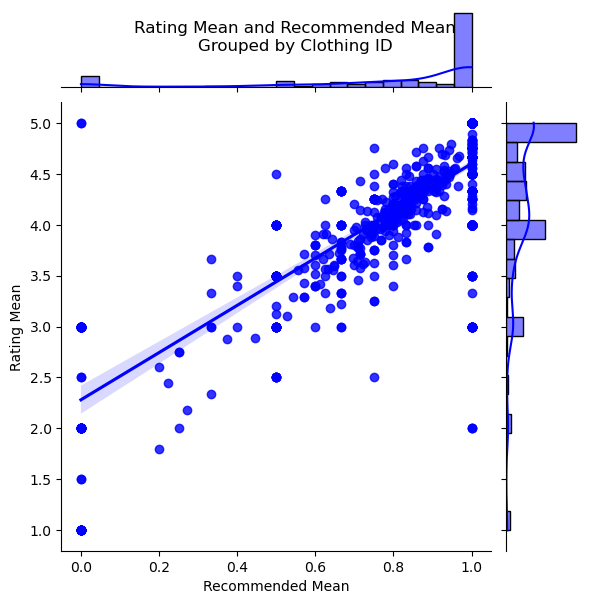

In [37]:
g = sns.jointplot(x= "Recommended Mean",y='Rating Mean',data=temp,
                  kind='reg', color='b')
plt.subplots_adjust(top=0.999)
g.fig.suptitle("Rating Mean and Recommended Mean\nGrouped by Clothing ID")
plt.show()

**Interpretation:** <br>
Here is a closer look at this correlation of interest. And look at that p-value! Someone call a publisher.

Jokes aside, perhaps the dots are the bottom left could be the products that unarguably need attention from the retailer, in the hope of preserving brand image.

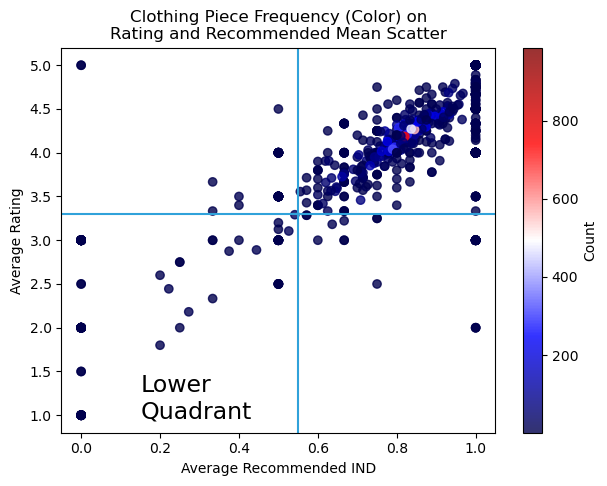

,Count,Rating Mean,Recommended Mean,Age Mean
count,204.000000,204.000000,204.000000,204.000000
mean,2.308824,2.763338,0.316315,41.883954
std,2.798261,0.819220,0.351723,10.858979
min,1.000000,1.000000,0.000000,20.000000
25%,1.000000,2.136364,0.000000,34.687500
50%,1.000000,3.000000,0.250000,41.142857
75%,2.000000,3.000000,0.500000,47.000000
max,24.000000,5.000000,1.000000,74.000000


In [38]:
plt.figure(figsize=(7,5))
plt.scatter(temp["Recommended Mean"],temp["Rating Mean"],
            alpha = .8, c =temp["Count"], cmap = 'seismic')
cbar = plt.colorbar() # Color bar. Vive la France!
cbar.set_label('Count', rotation=90)
plt.xlabel("Average Recommended IND")
plt.ylabel("Average Rating")
plt.title("Clothing Piece Frequency (Color) on\nRating and Recommended Mean Scatter")

# Vertical and Horizontal Lines
l = plt.axhline(y=3.3)
l = plt.axvline(x=.55)

# Text
plt.text(.15, 1, "Lower\nQuadrant", ha='left',wrap=True,fontsize=17)
plt.show()

# Descriptives for LOW QUADRANT
temp[(temp["Rating Mean"] < 3.3) | (temp["Recommended Mean"] <= .55)].describe()

Follow-up on the previous correlation plot. This plot displays that these outliers are not very strongly represented. Indeed, the average count for the **LOW QUADRANT**, as labeled at the bottom left of the plot, is only 2.3. For these reasons, hyper negative reviews may be unrepresentative outliers, and not taken as the public's general opinion. 

A practise I could envision tackling this problem is to include the average rating of the product class, such as "Dress", in order to relieve customers who may be worried about product with low, hyper negative reviews.

***
**Correlating Average Rating and Recommended IND by Class Name** <br>
- [Stackoverflow Annotating Outliers](https://stackoverflow.com/questions/43010462/annotate-outliers-on-seaborn-jointplot)

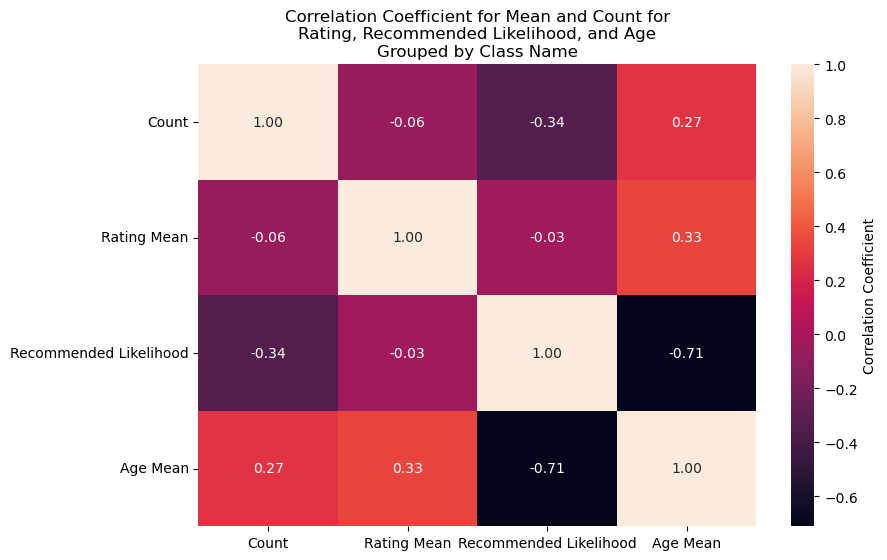

Class Categories:
 ['Intimates' 'Dresses' 'Pants' 'Blouses' 'Knits' 'Outerwear' 'Lounge'
 'Sweaters' 'Skirts' 'Fine gauge' 'Sleep' 'Jackets' 'Swim' 'Trend' 'Jeans'
 'Legwear' 'Shorts' 'Layering' 'Casual bottoms' 'Chemises']


In [39]:
key = "Class Name"
temp = (df.groupby(key)[["Rating","Recommended IND", "Age"]]
        .aggregate(['count','mean']))
temp.columns = ["Count","Rating Mean","Recommended Likelihood Count",
                "Recommended Likelihood","Age Count","Age Mean"]
temp.drop(["Recommended Likelihood Count","Age Count"], axis=1, inplace =True)

# Plot Correlation Matrix
f, ax = plt.subplots(figsize=[9,6])
ax = sns.heatmap(temp.corr()
    , annot=True, fmt=".2f",cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title("Correlation Coefficient for Mean and Count for\nRating, Recommended Likelihood, and Age\nGrouped by {}".format(key))
plt.show()
print("Class Categories:\n",df["Class Name"].unique())

**Interpretation:** <br>
For the various Class cateogries there a notable correlation between average age and recommendation likelihood. I shall investigate.

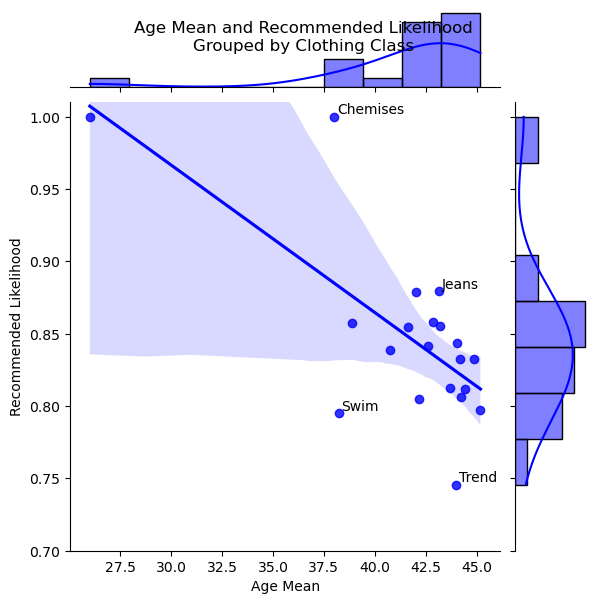

,Count,Rating Mean,Recommended Likelihood,Age Mean,resid
Class Name,,,,,
Casual bottoms,1,4.0,1.0,26.0,-0.007388
Chemises,1,4.0,1.0,38.0,0.114893


In [40]:
# Simple Linear Regression Model
model_fit = sm.OLS(temp["Recommended Likelihood"],
               sm.add_constant(temp["Age Mean"])).fit() 
temp['resid'] = model_fit.resid

# Plot
g = sns.jointplot(y="Recommended Likelihood",x='Age Mean',data=temp,
                  kind='reg', color='b')
plt.subplots_adjust(top=0.999)
g.fig.suptitle("Age Mean and Recommended Likelihood\nGrouped by Clothing Class")
plt.ylim(.7, 1.01)

# Annotate Outliers
head = temp.sort_values(by=['resid'], ascending=[False]).head(2)
tail = temp.sort_values(by=['resid'], ascending=[False]).tail(2)

def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=( r["Age Mean"], r["Recommended Likelihood"]), 
            xytext=(2,2) , textcoords ="offset points", )

for row in head.iterrows():
    ann(row)
for row in tail.iterrows():
    ann(row)

plt.show()
del head, tail

temp[temp["Recommended Likelihood"] > .95]

**Interpretation:** <br>
Check out my [**Other Kernel: In-Depth Simple Linear Regression
**](https://www.kaggle.com/nicapotato/in-depth-simple-linear-regression) for a deep dive into this regression.

***

## 5.  Working with Text <a id="Text"></a>

Now that a general understanding of the variables have been laid out, I will begin to analysis the customer reviews.

### 5.1 Text Pe-Processing

In [41]:
pd.set_option('max_colwidth', 500)
df[["Title","Review Text", "Rating"]].sample(7)

,Title,Review Text,Rating
7164,NaN,I tried this on in store in a small and then ordered the medium online i loved it so much! i generally run a small/medium with retailer so i thought this was pretty true to size. i'm also longer through the torso so the medium is better for me to cover my stomach when tied. it is on the thinner side but not see through. perfect for layering and for a mild california winter. can't wait for it to come!,5
4149,Love the color!,The raspberry color is really stunning! i have been looking for colored tights for a while and had difficulty finding really rich colors. i was thrilled when i saw these! i've worn them once so far. very comfortable and seem like they will last.,5
5451,Beautiful soft sweater,This green sweater is solo pretty . i wanted it from the moment i saw it. pretty layers on the bottom make it so unique!,5
20329,Comfy top,"I bought the black and love it. i bought both the medium and large but am going to keep the medium. it was plenty roomy. i'm 5'2"" and about fluctuate between 125-130 lbs. i usually wear a medium or large in retailer-wear but i like things roomy. have to hide a little extra these days!",5
2423,Lightweight and holds their shape,"Got these shorts in both colors: the blue-gray and the red-pink. super lightweight in hot humd weather, and keeps a crisp shape (doesn't get wrinkly and saggy like other linen shorts do). really nice quality interior finish and both front and back pockets are a usable depth.\r\n.\r\nif you're between sizes go for the smaller as they do stretch a bit over the day. i got these in a size 2 and they get a little loose on my 33""-25""-37ish"" frame. i'm 5'2"" and the petite was sold out, so i don't k...",5
14902,Beautiful but doesn't hold up well,"Beautiful. got several compliments when wearing it. does not hold up with washes though. threads unraveling everywhere. i am thinking of returning it for this reason. fits true to size. i am 5'4"" 118 lbs, xs fit. i am smaller on top.",3
9240,NaN,"Beautiful! caught my eye online. i had to order then reorder in a smaller size, but it is wonderful. colors are beautiful.",5


Evidently, the text data requires further processing .

In [42]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
#ps = LancasterStemmer()
ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    words = [w for w in words if not w in stop_words] #3
    #words = [ps.stem(w) for w in words] #4
    return words

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - 'C:\\Users\\ASUS/nltk_data'
    - 'C:\\ProgramData\\anaconda3\\nltk_data'
    - 'C:\\ProgramData\\anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\ASUS\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**Code Explanation:** <br>
This chunk of code creates a function that takes each review and combines them into one seamless text. It then applies lowercase, tokenizer, removes stopwords and punctuation, and finally uses the PorterStemmer.

***

**Interpretation:** <br>
In order to process the data set's centerpiece, the review body, I utilized the NLTK package to lowercase, tokenize, and remove stopwords and punctuation. Tokenizing treats each word as its own value, while the other steps gets rid of the noise and irrelevant symbols in the data, standardizing the reviews for analysis. Upon reviewing the performance of text analysis, I decided to implement the Porter Stemmer on the tokens in order to combine words with tense and plurality deviance. I contemplated exploring the use of sequential models, such as Long Short-term memory, which would benefit from stop words, but unfortunately I could only find predictive applications of it, no insight extracting aspects. 

The last piece of data transformation conducted was to bin the continuous variable age into a categorical variable: age category.

***

### 5.2 Sentiment Analysis <a id="Sentiment Analysis"></a>

My first attempt at understanding the customer reviews is to see how the textual sentiment relates to the rating scores. With this method, it will be possible to distinguish outright positive and negative comments from the constructive variant.

I will also explore the interaction between sentiment score:
- Raiting
- Recommended
- Positive Feedback Count

In [43]:
# Pre-Processing
SIA = SentimentIntensityAnalyzer()
df["Review Text"]= df["Review Text"].astype(str)

# Applying Model, Variable Creation
df['Polarity Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['compound'])
df['Neutral Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neu'])
df['Negative Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neg'])
df['Positive Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['pos'])

# Converting 0 to 1 Decimal Score to a Categorical Variable
df['Sentiment']=''
df.loc[df['Polarity Score']>0,'Sentiment']='Positive'
df.loc[df['Polarity Score']==0,'Sentiment']='Neutral'
df.loc[df['Polarity Score']<0,'Sentiment']='Negative'

LookupError: 
**********************************************************************
  Resource [93mvader_lexicon[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('vader_lexicon')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93msentiment/vader_lexicon.zip/vader_lexicon/vader_lexicon.txt[0m

  Searched in:
    - 'C:\\Users\\ASUS/nltk_data'
    - 'C:\\ProgramData\\anaconda3\\nltk_data'
    - 'C:\\ProgramData\\anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\ASUS\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


#### **Code Explanation:** <br>
*Pre-processing* chunk loads the NLTK Sentiment Intensity Analyzer module, selects desired variables, and finally applies lowercasing to the column of reviews in the dataframe. The second paragraph of code *Applying Model and Variable Creation* classifies each review in the dataset on three dimensions: Positive, Neutral, and Negative. These results are stored in three respective columns. The overall sentiment is then determined and stored in the Sentiment column.

- **Neutral/Negative/Positive Score:** Indicates the potency of these classes between 0 and 1. Onl
- **Polarity Score:** Measures the difference between the Positive/Neutral/Negative values, where a positive numbers closer to 1 indicates overwhelming positivity, and a negative number closer to -1 indicates overwhelming negativity.

***

**Normalize Plots for Sentiment Distribution**

ValueError: Could not interpret input 'Sentiment'

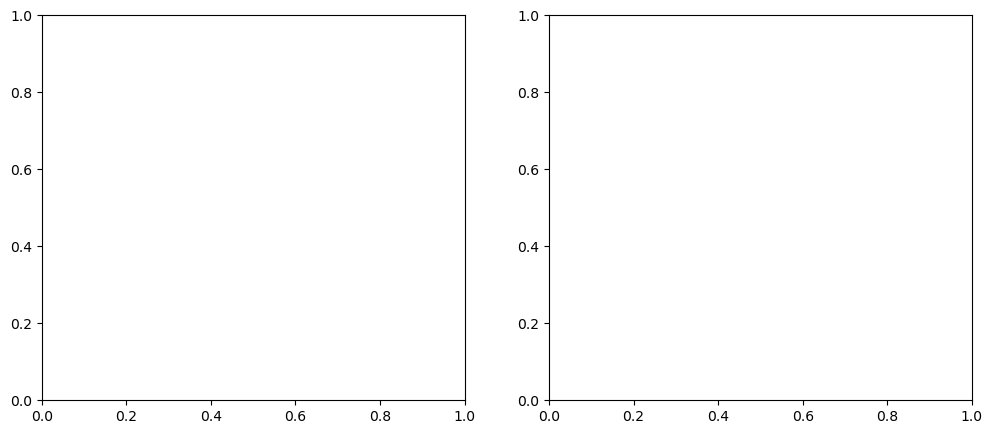

In [44]:
huevar = "Recommended IND"
xvar = "Sentiment"
f, axes = plt.subplots(1,2,figsize=(12,5))
sns.countplot(x=xvar, hue=huevar,data=df, ax=axes[0], order=["Negative","Neutral","Positive"])
axes[0].set_title("Occurence of {}\nby {}".format(xvar, huevar))
axes[0].set_ylabel("Count")
percentstandardize_barplot(x=xvar,y="Percentage", hue=huevar,data=df, ax=axes[1])
axes[1].set_title("Percentage Normalized Occurence of {}\nby {}".format(xvar, huevar))
axes[1].set_ylabel("% Percentage by {}".format(huevar))
plt.show()

**Interpretation:** <br>
Recommended is a variable that clearly indicates positive sentiment in the review.

In [ ]:
f, axes = plt.subplots(2,2, figsize=[9,9])
sns.countplot(x="Sentiment", data=df, ax=axes[0,0], order=["Negative","Neutral","Positive"])
axes[0,0].set_xlabel("Sentiment")
axes[0,0].set_ylabel("Count")
axes[0,0].set_title("Overall Sentiment Occurrence")

sns.countplot(x="Rating", data=df, ax=axes[0,1])
axes[0,1].set_xlabel("Rating")
axes[0,1].set_ylabel("")
axes[0,1].set_title("Overall Raiting Occurrence")

percentstandardize_barplot(x="Rating",y="Percentage",hue="Sentiment",data=df, ax=axes[1,0])
axes[1,0].set_xlabel("Rating")
axes[1,0].set_ylabel("Percentage %")
axes[1,0].set_title("Standardized Percentage Raiting Frequency\nby Sentiment")

percentstandardize_barplot(x="Sentiment",y="Percentage",hue="Rating",data=df, ax=axes[1,1])
axes[1,1].set_ylabel("Occurrence Frequency")
axes[1,1].set_title("Standardized Percentage Sentiment Frequency\nby Raiting")
axes[1,1].set_xlabel("Sentiment")
axes[1,1].set_ylabel("")

f.suptitle("Distribution of Sentiment Score and Rating for Customer Reviews", fontsize=14)
f.tight_layout()
f.subplots_adjust(top=0.92)
plt.show()

**Code Interpretation:** <br>
The last chunk, Visualization, plots the frequency of sentiments in a bar plot using matplotlib.

**Interpretation:** <br>
Like the distribution of rating, most reviews have a positive sentiment. Unlike the distribution of rating, there is a lower occurrence of neutral rating is lower in proportion to the occurrence of medium ranged ratings.

The plot on the bottom right tells and interesting story. The rating of positive sentiment reviews have an increasing occurrence as the rating gets higher. But, but negative and neutral sentiment reviews, the highest occurrence rating has 3 rating, further emphasizing that people's motivation of assigning a review score of three are multiple.

***

In [ ]:
# Tweakable Variables (Note to Change Order Arguement if Xvar is changed)
xvar = "Sentiment"
huevar = "Department Name"
rowvar = "Recommended IND"

# Plot
f, axes = plt.subplots(2,2,figsize=(10,10), sharex=False,sharey=False)
for i,x in enumerate(set(df[rowvar][df[rowvar].notnull()])):
    percentstandardize_barplot(x=xvar,y="Percentage", hue=huevar,data=df[df[rowvar] == x],
                 ax=axes[i,0], order=["Negative","Neutral","Positive"])
    percentstandardize_barplot(x=xvar,y="Percentage", hue="Rating",data=df[df[rowvar] == x],
                 ax=axes[i,1], order=["Negative","Neutral","Positive"])

# Plot Aesthetics
axes[1,0].legend_.remove()
axes[1,1].legend_.remove()
axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")
axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
axes[0,0].set_ylabel("Recommended = FALSE\nPercentage %")
axes[1,0].set_ylabel("Recommended = TRUE\nPercentage %")
axes[1,1].set_title("")

# Common title and ylabel
f.text(0.0, 0.5, 'Subplot Rows\nSliced by Recommended', va='center', rotation='vertical', fontsize=12)
f.suptitle("Review Sentiment by Department Name and Raiting\nSubplot Rows Slice Data by Recommended", fontsize=16)
f.tight_layout()
f.subplots_adjust(top=0.93)
plt.show()

**How to Interpret:** <br>
In this plot, the upper and lower rows use the same variables, but the upper row is for non-recommended reviews, while the bottom row is for recommended reviews. This enables use to explore the nature of recommended reviews in terms of the mood of the writing, as well as the rating assigned by the customer.

**Interpretation:** <br>
While the distribution of departments does not seem to change depending on status of recommendation, rating is almost entirely inverted. My previous theory that recommended reviews hold more criticizing  weight does not hold up in this case since recommended reviews have a highly positive sentiment occurrence.

In [ ]:
# Plot Correlation Matrix
f, ax = plt.subplots(figsize=[9,6])
ax = sns.heatmap(df.corr(), annot=True,
                 fmt=".2f",cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title("Correlation Matrix for All Variables")
plt.show()

# Sentiment Positivity Score by Positive Feedback Count
ax = sns.jointplot(x= df["Positive Feedback Count"], y=df["Positive Score"], kind='reg', color='r')
plt.show()

**Interpretation:** <br>
Interestingly, there appears to be a substantial negative correlation between Positive Feedback Count and Positive Score, which suggests that the most acclaimed reviews on the platform are probably in the form on constructive criticism, rather than outright positivity.
***

## 6. Word Distribution and Word Cloud <a id="Word Distribution and Word Cloud"></a> <br>

** For this section, I deviated from the book and heavily relied upon the following online resources:** <br>
- [Kaggle Longdoa: Word Cloud in Python](https://www.kaggle.com/longdoan/word-cloud-with-python)
- [Word Cloud Package Forum](https://github.com/amueller/word_cloud/issues/134)
- [Amueller Github](https://amueller.github.io/word_cloud/auto_examples/masked.html)

In [ ]:
stopwords = set(STOPWORDS)
size = (10,7)

def cloud(text, title, stopwords=stopwords, size=size):
    """
    Function to plot WordCloud
    Includes: 
    """
    # Setting figure parameters
    mpl.rcParams['figure.figsize']=(10.0,10.0)
    mpl.rcParams['font.size']=12
    mpl.rcParams['savefig.dpi']=100
    mpl.rcParams['figure.subplot.bottom']=.1 
    
    # Processing Text
    # Redundant when combined with my Preprocessing function
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black',
                          stopwords=stopwords,
                         ).generate(str(text))
    
    # Output Visualization
    fig = plt.figure(figsize=size, dpi=80, facecolor='k',edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=50,color='y')
    plt.tight_layout(pad=0)
    plt.show()
    
# Frequency Calculation [One-Gram]
def wordfreqviz(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    matplotlib.style.use('ggplot')
    rslt.plot.bar(rot=0)

def wordfreq(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    return rslt

#### **Code Explanation:** <br>
This code creates the word cloud visualization function. This function’s mathematical processes are hidden, since it does not explicitly state that it determines the frequency occurrence of each word in relation to the entire dictionary of words. Within the function, the Setting Function Parameter section creates the graphic structure using matplotlib. Then the text is formatted, and the word frequency is determined. Finally, the matplotlib structure is filled with words, where the larger the word size, the higher the word occurrence. 

### Visualize Titles

In [ ]:
# Modify Stopwords to Exclude Class types, suchs as "dress"
new_stop = set(STOPWORDS)
new_stop.update([x.lower() for x in list(df["Class Name"][df["Class Name"].notnull()].unique())]
                + ["dress", "petite"])

# Cloud
cloud(text= df.Title[df.Title.notnull()].astype(str).values,
      title="Titles",
      stopwords= new_stop,
      size = (7,4))

### Visualize Reviews

In [ ]:
# Highly Raited
title ="Highly Rated Comments"
temp = df['Review Text'][df.Rating.astype(int) >= 3]

# Modify Stopwords to Exclude Class types, suchs as "dress"
new_stop = set(STOPWORDS)
new_stop.update([x.lower() for x in list(df["Class Name"][df["Class Name"].notnull()].unique())]
                + ["dress", "petite"])

# Cloud
cloud(text= temp.values, title=title,stopwords= new_stop)

# Bar Chart
wordfreq(preprocessing(temp),20).plot.bar(rot=45, legend=False,figsize=(15,5), color='g',
                          title= title)
plt.ylabel("Occurrence Count")
plt.xlabel("Most Frequent Words")
plt.show()

# Low Raited
title ="Most Frequent Words in Low Rated Comments"
temp = df['Review Text'][df.Rating.astype(int) < 3]

# Modify Stopwords to Exclude Class types, suchs as "dress"
new_stop = set(STOPWORDS)
new_stop.update([x.lower() for x in list(df["Class Name"][df["Class Name"].notnull()].unique())]
                + ["dress", "petite", "skirt","shirt"])

# Cloud
cloud(temp.values, title= title, stopwords = new_stop)

#### **Code Interpretation:** <br>
The central flaw of these word clouds is that they only show the distribution of individual words. This removes the context of the word, as well as disregard negative prefixes. In order to solve this problem I will utilize n-grams, which increases the size of observed values from one word to multiple words, enabling frequency counts to be conducted to word sequences. Although I would have prefered to visualize these findings through the use of Word Clouds, I was unable to program this in, thus leaving me with a simple table.

**Taking a Different Lense: WordClouds by Department Name** <br>

In [ ]:
department_set = df["Department Name"][df["Department Name"].notnull()].unique()
division_set = df["Division Name"][df["Division Name"].notnull()].unique()
def cloud_by_category(data, category, subclass):
    """
    Function to create a wordcloud by class and subclass
    Category signifies the column variable
    Subclass refers to the specific value within the categorical variable
    """
    new_stop = set(STOPWORDS)
    new_stop.update([x.lower() for x in list(data["Class Name"][data["Class Name"].notnull()].unique())]
                   + [x.lower() for x in list(data["Department Name"][data["Department Name"].notnull()].unique())]
                   + ["dress", "petite", "jacket","top"])

    # Cloud
    cloud(text= data["Review Text"][data[category]== subclass],
          title="{}".format(subclass),
          stopwords= new_stop,
          size = (10,6))
    
# Plot
cloud_by_category(df, "Division Name", division_set[0])
cloud_by_category(df, "Division Name", division_set[1])
cloud_by_category(df, "Division Name", division_set[2])

***
## 7. N Grams by Recommended Feature
<a id="NGRAM"></a>

At this point, fit and product inconsistency strongly emerge as major topics in the reviews. From this information, I can infer that the dataset belongs to a online retailer, since brick and mortar stores have changing rooms to prevent this problem. The central themes in the product reviews brought to light by the n-grams are:
- **Fit:** Whether the product’s advertised size actually corresponds to customer size and height.
- **Love or Hate:** The customer's personal feelings towards the product.
- **Complements:** The customer's social experience wearing the product.
- **Product consistency:** Whether the product appears as advertised, lives up to quality expectations.

In [ ]:
## Helper Functions
from nltk.util import ngrams
from collections import Counter
def get_ngrams(text, n):
    n_grams = ngrams((text), n)
    return [ ' '.join(grams) for grams in n_grams]

def gramfreq(text,n,num):
    # Extracting bigrams
    result = get_ngrams(text,n)
    # Counting bigrams
    result_count = Counter(result)
    # Converting to the result to a data frame
    df = pd.DataFrame.from_dict(result_count, orient='index')
    df = df.rename(columns={'index':'words', 0:'frequency'}) # Renaming index column name
    return df.sort_values(["frequency"],ascending=[0])[:num]

def gram_table(data, gram, length):
    out = pd.DataFrame(index=None)
    for i in gram:
        table = pd.DataFrame(gramfreq(preprocessing(data),i,length).reset_index())
        table.columns = ["{}-Gram".format(i),"Occurrence"]
        out = pd.concat([out, table], axis=1)
    return out

In [ ]:
print("Non-Recommended Items")
gram_table(data= df['Review Text'][df["Recommended IND"].astype(int) == 0], gram=[1,2,3,4,5], length=30)

In [ ]:
print("Recommended Items")
gram_table(data= df['Review Text'][df["Recommended IND"].astype(int) == 1], gram=[1,2,3,4,5], length=30)

**Interpretation:** <br>
In the negative reviews, customers express their disappointment in the product, stating that they “really wanted to love” the item. This signifies that the product did not live up to the customers expectations. This occurred for multiple reasons. “Order wear size” and “Usual wear size” suggest that the fit did not suit their typical universal body size. Perhaps if better product dimension information could be provided, then the likelihood of this negative response could decrease. Furthermore, perhaps the product platform could track the user’s size through previous purchase in order to warn customer for potential size conflict.
Another form of negative review is in the disappointment in the product turnout. “Too much fabric” and “Looks nothing like” suggest inconsistency with online retail presentation and actual product. These reviews are especially destructive, since they damage the reputation of the store product quality, which is a online platforms biggest asset.
On the other hand, positive reviews are void of criticism, and are preoccupied with confirming fit and sharing social experience with the clothing. “True Size”, “Fit Perfectly”, “Fit like a glove”, on top of the multiple 2-grams with customer’s height suggest that a large part of positive reviews are employed to confirm product fit according to certain size. The high occurrence of this review suggest that height and size is usually a big issue, which this retail managed to consistently satisfy.
“Received many compliments”, “Look forward to wearing”, “Everytime I wear”, “Looks great with jeans” are all comments which reflect the customer's experience wearing the product out in public. This not only express the relevance of trendy, jaw dropping fashion for customers in a social context, but also suggests that the product review are a highly social space, in which customers not only talk with the retailer, but with the other customers as well.

***

## 8. Intelligible Supervised Learning

Supervised learning requires features (independent variable) and a label (dependent variable).  The Formatting section does just this by creating a tuple with the comment and customer rating label. Currently the independent variable is the entire comment. However, in order to the Naïve Bayes Algorithm to work, each word must be treated as a variable. Instead of utilizing sequential words, the model notes which words are present out of the entire dictionary of words available in the comments corpus. In order to reduce computational intensity, only the top 5000 most common words will be considered, instead of the 9000 unique words in the corpus. The find_features function does just this by checking the presence of words for a piece of text against word_features, a variable created earlier which includes the top 5000 most common words used by customers in this dataset. The Apply Function to Data section applies the find_features function to each individual customer review using a loop, while also retaining each review’s label.

In [ ]:
df['tokenized'] = df["Review Text"].astype(str).str.lower() # Turn into lower case text
df['tokenized'] = df.apply(lambda row: tokenizer.tokenize(row['tokenized']), axis=1) # Apply tokenize to each row
df['tokenized'] = df['tokenized'].apply(lambda x: [w for w in x if not w in stop_words]) # Remove stopwords from each row
df['tokenized'] = df['tokenized'].apply(lambda x: [ps.stem(w) for w in x]) # Apply stemming to each row
all_words = nltk.FreqDist(preprocessing(df['Review Text'])) # Calculate word occurrence from whole block of text

vocab_count = 200
word_features= list(all_words.keys())[:vocab_count] # 2000 most recurring unique words
print("Number of words columns (One Hot Encoding): {}".format(len(all_words)))


**Converting Text to a Model-able format: One Hot Encoding**

In [ ]:
# Tuple
labtext= list(zip(df.tokenized, (df["Recommended IND"]))) 

# Function to create model features
# for each review, records which unique words out of the whole text body are present
def find_features(document):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features
# Apply function to data
featuresets = [(find_features(text), LABEL) for (text, LABEL) in labtext]
len(featuresets)

# Train/Test
training_set = featuresets[:15000]
testing_set = featuresets[15000:]

## 8.1 Naive Bayes

- Independent Variable: Word choices in Reviews
- Dependent Variable: Whether or not review was Recommended

Supervised learning is typically employed to make predictions about the future. However, some simple models may also be opened up to offer some insight. Naive Bayes is a probabilistic model which depends on Bayes theorem to compute the probability of a word's category by looking at its occurrence over the different classes. Since this model looks at both good and bad reviews, it is able to extract the one-gram tokens which best polarize the categories. Using this model, I could potentially predict the positive or negative sentiment of unlabelled reviews.

In [ ]:
# Posterior = prior_occurrence * likelihood / evidence
classifier = nltk.NaiveBayesClassifier.train(training_set)

# Output
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)
print(classifier.show_most_informative_features(40))

**How to Interpret the Table:** <br>
The first column displays the word, the second represents whether the word is not-recommended (0:1), or recommended (1:0). Lastly, the third column shows the ratio of occurrence. Looking at the first column, *“worst” *is a non-recommended word, whose presence indicates the review is 23 times more likely to be negative than positive. This model’s accuracy is 82%. Naive Bayes’ predictive power is limited compared to other, more complex models, but accuracy is not the goal for this analysis.
***
## Key Findings
- Product recommendation and Product rating are used for different purposes.
    - Recommended is a strong indicator for positive sentiment in the review.
    - Rating is more convoluted, where rating around 3 are hopeful reviews with constructive criticism of the product.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scikitplot as skplt
import eli5

In [ ]:
vect = TfidfVectorizer()
vect.fit(df["Review Text"])
X = vect.transform(df["Review Text"])

In [ ]:
y = df["Recommended IND"].copy()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.20, random_state=23, stratify=y)

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
print("Train Set Accuracy: {}".format(metrics.accuracy_score(model.predict(X_train), y_train)))
print("Train Set ROC: {}\n".format(metrics.roc_auc_score(model.predict(X_train), y_train)))

print("Validation Set Accuracy: {}".format(metrics.accuracy_score(model.predict(X_valid), y_valid)))
print("Validation Set ROC: {}".format(metrics.roc_auc_score(model.predict(X_valid), y_valid)))

In [ ]:
print(metrics.classification_report(model.predict(X_valid), y_valid))

In [ ]:
# Confusion Matrix
skplt.metrics.plot_confusion_matrix(model.predict(X_valid), y_valid, normalize=True)
plt.show()

## ELI5

In [ ]:
target_names = ["Not Recommended","Recommended"]
eli5.show_weights(model, vec=vect, top=100,
                  target_names=target_names)

In [ ]:
for iteration in range(15):
    samp = random.randint(1,df.shape[0])
    print("Real Label: {}".format(df["Recommended IND"].iloc[samp]))
    display(eli5.show_prediction(model,df["Review Text"].iloc[samp], vec=vect,
                         target_names=target_names))

## LGBM and SHAP

In [ ]:
import lightgbm as lgb

print("Light Gradient Boosting Classifier: ")
lgbm_params = {
        "objective": "binary",
        'metric': {'auc'},
        "boosting_type": "gbdt",
        "num_threads": 4,
        "bagging_fraction": 0.8,
        "feature_fraction": 0.8,
        "learning_rate": 0.1,
        "num_leaves": 31,
        "min_split_gain": .1,
        "reg_alpha": .1
    }

modelstart= time.time()
# LGBM Dataset Formatting 
lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=vect.get_feature_names())
lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=vect.get_feature_names())

In [ ]:
# Go Go Go
lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=2000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=150,
    verbose_eval=100
)

In [ ]:
valid_pred = lgb_clf.predict(X_valid)
_thresh = []
for thresh in np.arange(0.1, 0.501, 0.01):
    _thresh.append([thresh, metrics.f1_score(y_valid, (valid_pred>thresh).astype(int))])
#     print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (valid_pred>thresh).astype(int))))

_thresh = np.array(_thresh)
best_id = _thresh[:,1].argmax()
best_thresh = _thresh[best_id][0]
print("Best Threshold: {}\nF1 Score: {}".format(best_thresh, _thresh[best_id][1]))

## SHAP

In [ ]:
import shap
shap.initjs()

non_sparse = pd.DataFrame(vect.transform(df['Review Text']).toarray(), columns = vect.get_feature_names())
print(non_sparse.shape)

explainer = shap.TreeExplainer(lgb_clf)
shap_values = explainer.shap_values(non_sparse)

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, non_sparse)

In [ ]:
# visualize the first prediction's explanation
for iteration in range(15):
    samp = random.randint(1,df.shape[0])
    print("Real Label: {}".format(df["Recommended IND"].iloc[samp]))
    display(df["Review Text"].iloc[samp])
    display(shap.force_plot(explainer.expected_value, shap_values[samp,:], non_sparse.iloc[samp,:]))

***
**Reflection:** <br>
I want to summarize my findings and experiment with some more statistical test. I personally have a hard time understanding the nuance and application of some statistical test, so I would like to see how their findings mirror my multivariate plots. I believe that visualizations are great for low-dimensionality data, but more scalable statistical methods must be understood in order to deal with messier situations.

**To Do:**
- I want to do some unsupervised learning, and make use of [**Clustering Dendrogram**](https://python-graph-gallery.com/404-dendrogram-with-heat-map/).
- Word Vectorization and Clustering.

*- Nick*